In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
from scipy import signal
from pandasql import sqldf
import seaborn as sns
import pingouin as pg
from collections import defaultdict
import glob
import statsmodels.api as sm
import ast
from scipy import stats

# Cracking the pitch code of music-motor synchronization using data-driven methods
&copy; Leo Migotti, Quentin Decultot, JJ Aucouturier, 2021-2022

The study of auditory-motor synchronization with music has been so far mostly concerned with timing. For instance, research has established that people are able to spontaneously coordinate with musical beat when walking or running (Styns et al. 2007). Yet, music is more than a metronome, and the relation between the spectral dimension of music, i.e. parameters such as its pitch, timber, or harmonic structure, and simultaneous motion  remains nearly unknown. 

Here, we introduce a novel data-driven paradigm in which participants were asked to walk on a treadmill while listening to a large variety of musical tones systematically varied in pitch. Using analysis techniques inspired by psychophysical reverse correlation, we show that participant gait patterns while walking to music spontaneously encode pitch height: despite being instructed to simply synchronize in time, participants steps were also both longer and heavier on tones with lower pitches. 

These findings reveal that, similarly to time perception, pitch cognition is at least partially embodied, and suggest that listeners' spontaneous motor reactions to pitch might ground their ability to mentally represent music.

## Materials and methods

### Participants

N=20 young (M=25.5, SD=7), western, educated participants (male: 11, female: 9) participated in the experiment. 

In [2]:
answers_msi = pd.read_csv('data/gold_msi.csv')

In [3]:
rename={'Horodateur':'date',
 'Numéro_de_participant':'participant',
 'Quel_est_votre_âge':'age',
 'Vous_considérez_vous_comme_musicien':'musician',
 'Civilité':'gender',
 'J_écoute_souvent_certaines_musiques_pour_me_motiver_ou_m_enthousiasmer':'MSI_MOTI',
 'Je_suis_capable_de_parler_des_émotions_qu_évoque_pour_moi_un_morceau_de_musique':'MSI_EMOT',
 'La_musique_peut_m_évoquer_des_souvenirs_de_personnes_ou_d_endroits_du_passé':'MSI_MEMO',
 'Je_consacre_une_partie_importante_de_mon_temps_libre_à_des_activités_liées_à_la_musique':'MSI_TIME',
 'Je_lis_ou_je_cherche_souvent_sur_internet_des_informations_en_lien_avec_la_musique':'MSI_INFO',
 'Je_ne_pourrais_pas_vivre_sans_musique':'MSI_LIFE',
 'Pendant_combien_de_temps_avez_vous_suivi_un_entraînement_formel_en_théorie_ou_en_pratique_de_la_musique_ex_cours_de_solfège_d_instrument':'time_training',
 'De_combien_d_instruments_de_musique_savez_vous_jouer':'nb_instrument',
 'Je_trouve_difficile_de_repérer_les_fautes_dans_l_exécution_d_une_chanson_ou_d_un_morceau_même_si_je_connais_la_mélodie':'MSI_DIFF',
 'Je_suis_capable_de_dire_si_quelqu_un_ne_chante_ou_ne_joue_pas_en_rythme':'MSI_RYTM',
 'Je_suis_capable_de_dire_quand_quelqu_un_chante_ou_joue_faux':'MSI_FAUX',
 'Je_suis_capable_de_trouver_les_bonnes_notes_lorsque_je_chante_accompagné_e_d_un_enregistrement':'MSI_ACCO',
 'Si_quelqu_un_chante_une_chanson_que_je_ne_connais_pas_je_peux_me_mettre_à_la_chanter_avec_lui_ou_avec_elle':'MSI_AVEC',
 'Je_n_aime_pas_chanter_en_public_car_j_ai_peur_de_chanter_les_mauvaises_notes':'MSI_PEUR',
 'Avez_vous_l_oreille_absolue':'absolu'}
answers_msi = answers_msi.rename(columns=rename)

In [4]:
recode_gender={'Monsieur':'M',
             'Madame':'F'}
answers_msi.gender = answers_msi.gender.apply(lambda val: recode_gender[val]) 

In [5]:
print(answers_msi.groupby(['gender']).participant.count())
print(answers_msi.age.describe())


gender
F     9
M    11
Name: participant, dtype: int64
count    20.000000
mean     25.550000
std       7.059708
min      19.000000
25%      21.000000
50%      23.000000
75%      26.500000
max      44.000000
Name: age, dtype: float64


N=13 participants (65\%) self-declared as musicians (M=8.6y of musical training). In addition, all participants completed a short self-report survey consisting of 15 items extracted from the Goldsmith Music Sophistication Index (MSI) measuring their active engagement with music, perceptual abilities, musical training and singing abilities. MSI scores significantly differed between musicians (M=51.4) and non-musicians (M=38.8; t(11.7)=2.66, p=.0209, \[2.26, 22.79\], Cohen's d=1.3). In the following, we coded participants as musicians based on their original self-report.  

In [6]:
recode_time={'2 ans':2,
             'Jamais':0,
             '3 à 5 ans':3,
             '10 ans et plus':10,
             '15 ans':15,
             '6 à 9 ans':6,
             '6 ans':5}
answers_msi.time_training = answers_msi.time_training.apply(lambda val: recode_time[val]) 

In [7]:
# deduce musical score from MSI test data
answers_msi['musical_score'] = (answers_msi.MSI_MOTI +
                                answers_msi.MSI_EMOT +
                                answers_msi.MSI_MEMO +
                                answers_msi.MSI_TIME +
                                answers_msi.MSI_INFO +
                                answers_msi.MSI_LIFE + 
                                (- answers_msi.MSI_DIFF) +
                                answers_msi.MSI_RYTM +
                                answers_msi.MSI_FAUX + 
                                answers_msi.MSI_ACCO +
                                answers_msi.MSI_AVEC +
                                ( - answers_msi.MSI_PEUR))


<Axes: xlabel='musician', ylabel='time_training'>

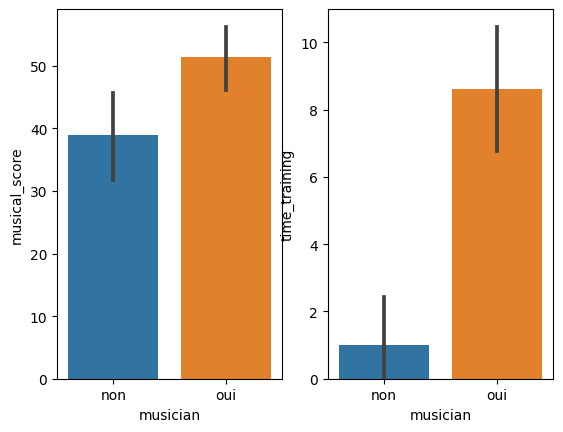

In [8]:
plt.subplot(1,2,1)
sns.barplot(data=answers_msi,
              x='musician',order=['non','oui'],
              y='musical_score')
plt.subplot(1,2,2)
sns.barplot(data=answers_msi,
              x='musician',order=['non','oui'],
              y='time_training')

In [9]:
answers_msi.groupby(['musician']).agg({'participant':'count','musical_score':'mean', 'time_training':'mean'})

,participant,musical_score,time_training
musician,,,
non,7,38.857143,1.000000
oui,13,51.384615,8.615385


In [10]:
pg.ttest(answers_msi[answers_msi.musician=='oui'].musical_score,answers_msi[answers_msi.musician=='non'].musical_score)

,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,2.666661,11.719178,two-sided,0.0209,"[2.26, 22.79]",1.275655,3.724,0.730311


<Axes: xlabel='musical_score', ylabel='Count'>

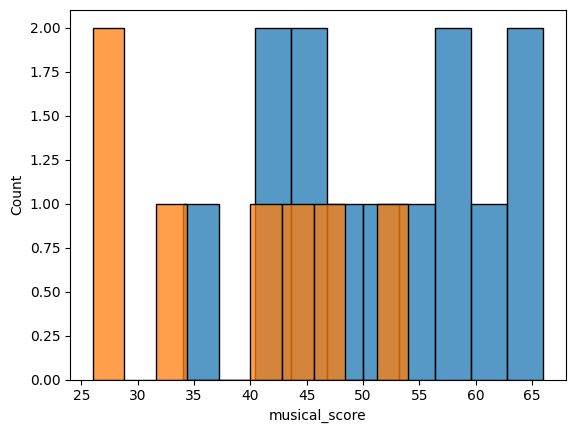

In [11]:
sns.histplot(answers_msi[answers_msi.musician=='oui'].groupby(['participant']).musical_score.mean(),  bins=10)
sns.histplot(answers_msi[answers_msi.musician=='non'].groupby(['participant']).musical_score.mean(),  bins=10)

In [12]:
answers_msi['musician_msi'] = answers_msi.musical_score >= answers_msi.musical_score.median() 
answers_msi.groupby(['musician_msi','musician']).participant.count()

musician_msi  musician
False         non         5
              oui         4
True          non         2
              oui         9
Name: participant, dtype: int64

### Procedure

We tasked our participants to walk on a force-sensing treadmill while listening to a large variety of musical tones systematically varied in pitch. 

Prior to each session, participants were asked to stand still once on each side of the treadmill for calibration. Treadmill was then started, its speed set at a slow walking speed (M=2.5km/h) and participants practiced walking to the sound of a metronome (75 bpm, period=0.8s) until they were comfortable with the task.

Participants were then instructed to walk on the treadmill and to synchronize their steps with a sequence of piano notes they heard through headphones, without the support of handrails and as naturally as possible. Each session used an uninterrupted sequence of 750 sound events, played at a constant rate of 75bpm (period=0.8s), amounting to a total of 10min. 

Participants were told a cover story that we were interested in how well people could adjust their timing to the period of the sounds, that the pitch content of the notes was irrelevant and just introduced for variety, and that they should focus their attention on walking synchronously with the sequence. Participants were then debriefed to the true purpose of the experiment, which was in fact to examine the effect of pitch height on their walking gate. 

### Apparatus

Step data was acquired using a legacy instrumented treadmill (<mark>XXX</mark>), equipped with two force platforms measuring the time series of forces of each limb during walking, along the X (medio-lateral), Y (antero-posterior) and Z (vertical) dimensions. The treadmill was interfaced to our software using a generic USB I/O acquisition card (NI-6008, National Instrument). Data was acquired at a sample rate of 1000Hz, and recorded continuously for the duration of one experiment (XXmin). 
While they walked on the treadmill, participants were presented with sequences of musical notes using commercial wireless headphones (Beats Solo3). Using custom software written in Python (https://github.com/neuro-team-femto/treadmill), we synchronized step data acquisition with the triggering of each musical note, in order to be able to associate the time series of each step to the corresponding sound event. 

### Sounds

Sound stimuli were extracted from the University of Iowa Musical Instrument Samples (MIS) dataset \url{https://theremin.music.uiowa.edu/MIS.html} and consisted in high-quality recordings of a Steinway & Sons model B piano, made in Nov. 2001 at the Voxman Auditorium, University of Iowa (Iowa City, USA) using a Neumann KM84 microphone. We selected one recording for each of the 24 notes spanning octaves 4 and 5, i.e. from C4 (263.3 Hz) to B5 (1016.0 Hz), by steps of one semitone), played at medium dynamics (_mf_). To ensure that stimuli could be accurately synchronized to step data later in the experiment, we then normalized the loudness of the files, trimmed any initial silence (using a threshold at -30dB) and faded out each recording after 1.5sec so that all had the same duration.

We then produced a second derivative dataset by applying an algorithmic pitch transformation (pitch shifting) to each of the original files, in such a way that its fundamental frequency was reduced by 10, 20, 30, 40 or 50\% of a semitone (or cents). Pitch shifting was done using a python implementation of the phase vocoder algorithm \cite{Burred}. Finally, we ran an automated pitch analysis algorithm (SWIPE, \cite{Caracho}) to document each musical note with its actual fundamental frequency, after pitch shifting. 
This resulted in a dataset of 240 musical notes, spanning the entire range of frequencies from a low-tuned C4 (255.8Hz) to a high-tuned B5 (1045.8Hz), by steps of 10% of a semitone (10 cents, corresponding to logarithmically increasing steps in Hz, from 1.5Hz at C4 to 5.9Hz at G5).

We then presented each participant with a random sequence of 750 sound events extracted from this dataset of 240-notes. Notes were played at the constant rate of 75bpm (period=0.8s), amounting to a total of 10min., and each note was repeated three consecutive times. In pilot studies, we experimented with several configurations, using only original recordings or using all pitch-shifted recordings, using notes from 2 octaves or 5 octaves, and using isolated or repeated notes. Because we found that, consistently with the literature (\cite{}), participants tended to anticipate the onset of the note to synchronize their steps (Figure XXX), we decided to present each note three consecutive times so that steps 2 and 3 could be initiated and performed after one complete hearing of the corresponding note.   





In [13]:
sounds_df = pd.read_csv('../experiment/sounds/list.csv')
print("Original C4 is %.1f Hz, and -50cents is %.1f Hz"%(float(sounds_df[sounds_df.note=='C4'].pitch),
      float(sounds_df[sounds_df.note=='C4'].pitch)*2**(-50/1200)))
print("Original B5 is %.1f Hz, and +50cents is %.1f Hz"%(float(sounds_df[sounds_df.note=='B5'].pitch),
      float(sounds_df[sounds_df.note=='B5'].pitch)*2**(+50/1200)))

Original C4 is 263.3 Hz, and -50cents is 255.8 Hz
Original B5 is 1016.0 Hz, and +50cents is 1045.8 Hz


### Step data signal processing

For each participant, we normalized the two time series of their left and right foot force data as percentage of the force corresponding to their standing weight, measured during calibration. We then resampled all time series at 100Hz and removed any linear trend across each session (due to treadmill electronics). Next, we segmented each participant's time series into individuel steps using a simple threshold procedure: candidate start- and endpoints for each step were positionned where the vertical force timeseries crossed (resp. upwards or downwards) a threshold set at 5% of the amplitude range of the series, and we eliminated false positives that had a step duration shorter than 100ms. Finally, we associated each step with its corresponding sound event by selecting, for each step, the first sound whose time onset was between the step's start and end point. Steps for which no sound events were found (e.g. after the sequence ended) were deleted from the dataset. 

#### Normalize, resample and detrend functions

##### Normalize by weight

In [14]:
def extract_weight(data):
    
    # find reset index, corresponding to change of foot
    reset_index = data[np.append([False],(np.diff(data.time)<0))].index[0]
    
    # tag foot
    data.loc[:reset_index,'foot']='left'
    data.loc[reset_index:,'foot']='right'
    
    # select median as mean weight per foot
    mean_weights = data.groupby(['foot'])[['z_left','z_right']].median().reset_index()
    min_weights = data.groupby(['foot'])[['z_left','z_right']].min().reset_index()
    
    left_weight = float(mean_weights[mean_weights.foot=='left'].z_left)
    left_zero = float(min_weights[min_weights.foot=='right'].z_left) # absolute minimum of left treadmill when all weight in on right foot
    
    right_weight = float(mean_weights[mean_weights.foot=='right'].z_right)
    right_zero = float(min_weights[min_weights.foot=='left'].z_right)# absolute minimum of right treadmill when all weight in on left foot
    
    return left_weight,left_zero,right_weight,right_zero

weight_data='treadmill_participant_1_21_06_15_10_04_weight.csv'
cols = ['time','x_left','y_left','z_left','x_right','y_right','z_right']
weight_data = pd.read_csv('data/'+weight_data)
weight_data[cols] = weight_data[cols].apply(pd.to_numeric)
    
left_weight,left_zero,right_weight,right_zero = extract_weight(weight_data)
print('left_weight: %f, left_zero: %f'%(left_weight,left_zero))
print('right_weight: %f, right_zero: %f'%(right_weight,right_zero))
       

left_weight: 1.479141, left_zero: -1.495401
right_weight: 2.710569, right_zero: -0.030261


In [15]:
def normalize_by_weight(df,left_weight,left_zero,right_weight,right_zero, error_threshold = [-0.5, 1.6], default_scale = 1.1):
    
     
    norm_df = df.copy()
    
    norm_df['z_left'] = (norm_df.z_left - left_zero)/(left_weight-left_zero)
    norm_df['z_right'] = (norm_df.z_right - right_zero)/(right_weight-right_zero)
    
    # rescale if values are abnormally high or low (e.g. because weight measure had problems)
    for feature in ['z_left','z_right']:
        if ((norm_df[feature].max()>error_threshold[1])|(norm_df[feature].min()<error_threshold[0])):
            print('ABNORMAL %s VALUE AFTER NORM: %f,%f'%(feature,norm_df[feature].min(),norm_df[feature].max()))
            norm_df[feature] = default_scale * (norm_df[feature] - norm_df[feature].min())/(norm_df[feature].max()- norm_df[feature].min())
    
    return norm_df

treadmill_data='treadmill_participant_19_order_1_21_06_23_10_05_data.csv'
cols = ['time','x_left','y_left','z_left','x_right','y_right','z_right']
treadmill_data = pd.read_csv('data/'+treadmill_data)
treadmill_data[cols] = treadmill_data[cols].apply(pd.to_numeric)

weight_data='treadmill_participant_19_21_06_23_10_05_weight.csv'
weight_data = pd.read_csv('data/'+weight_data)
weight_data[cols] = weight_data[cols].apply(pd.to_numeric)
left_weight,left_zero,right_weight,right_zero = extract_weight(weight_data)
print('left_weight: %f, left_zero: %f'%(left_weight,left_zero))
print('right_weight: %f, right_zero: %f'%(right_weight,right_zero))

norm_df = normalize_by_weight(treadmill_data,left_weight,left_zero,right_weight,right_zero)
norm_df.agg({'z_left':['min','max'],'z_right':['min','max']})
    

left_weight: -0.046331, left_zero: -1.253465
right_weight: 0.407864, right_zero: -0.631410
ABNORMAL z_left VALUE AFTER NORM: -0.902954,1.238397
ABNORMAL z_right VALUE AFTER NORM: -0.049020,2.225490


,z_left,z_right
min,0.0,0.0
max,1.1,1.1


##### Resample

['time', 'x_left', 'y_left', 'z_left', 'x_right', 'y_right', 'z_right', 'participant', 'config_file', 'order', 'condition_name']
['x_left', 'y_left', 'z_left', 'x_right', 'y_right', 'z_right', 'time', 'participant', 'config_file', 'order', 'condition_name']


Text(0.5, 1.0, '100Hz')

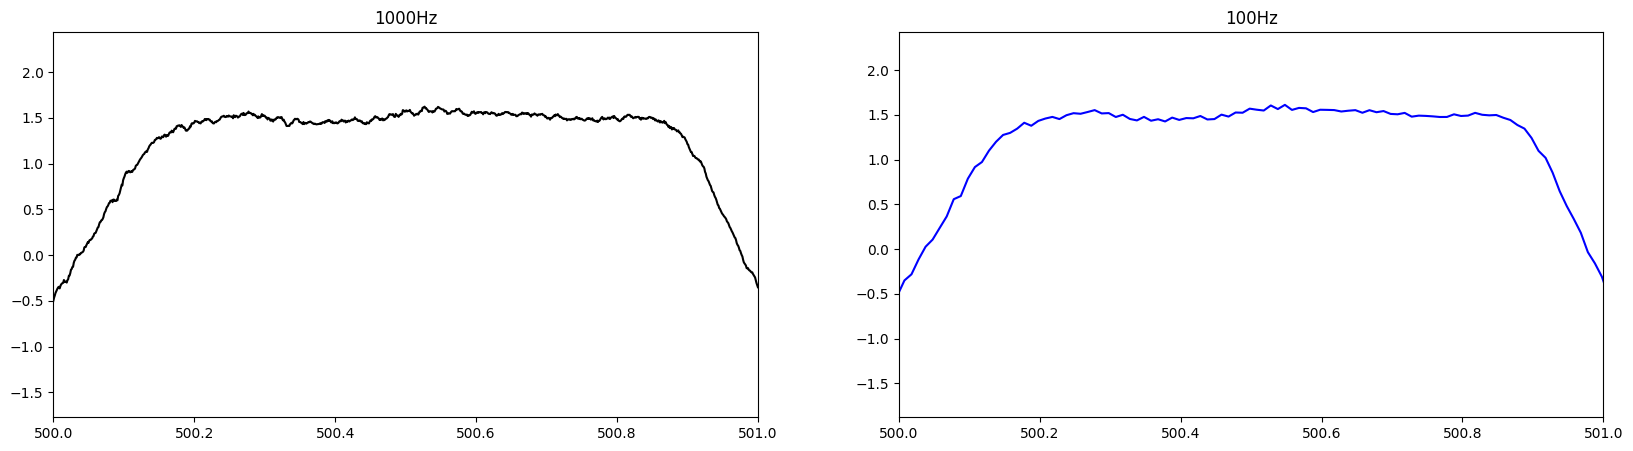

In [16]:
def resample_all_cols(df, sr=1000, new_sr=100, time_col='time'): 
    # resample all data columns to new_sr
    # not in place (copies df to new df)
    
    # list data columns 
    data_cols = ['x_left','y_left','z_left','x_right','y_right','z_right']
    non_data_cols = list(df)
    for data_col in data_cols: 
        non_data_cols.remove(data_col) 
    non_data_cols.remove(time_col)
    
    # resample data cols
    resampled_df = pd.DataFrame()
    for data_col in data_cols: 
        data = np.array(df[data_col])
        time = np.array(df[time_col])
        (new_data,new_time) = signal.resample(data,
                                t=time,
                                num = int((len(data)/sr)*new_sr))
        resampled_df[data_col] = new_data
    
    # add resampled time    
    resampled_df['time'] = new_time
    
    # add non_data columns
    resampled_df[non_data_cols] = df[non_data_cols]
    
    return resampled_df

# test
treadmill_data='treadmill_participant_1_order_1_21_06_15_10_04_data.csv'
cols = ['time','x_left','y_left','z_left','x_right','y_right','z_right']
treadmill_data = pd.read_csv('data/'+treadmill_data)
treadmill_data[cols] = treadmill_data[cols].apply(pd.to_numeric)
sr=1000
print(list(treadmill_data))

rs_data = resample_all_cols(treadmill_data)

print(list(rs_data))


# plot original vs resampled 
x = np.array(treadmill_data['z_left'])
t = np.array(treadmill_data['time'])
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,2,1)
plt.plot(t/1000,x,'k')
plt.xlim([500, 501])
plt.title('%dHz'%sr)
ax = fig.add_subplot(1,2,2)
x = np.array(rs_data['z_left'])
t = np.array(rs_data['time'])
plt.plot(t/1000,x,'b')
plt.xlim([500, 501])
plt.title('%dHz'%100)

##### Detrend

['x_left', 'y_left', 'z_left', 'x_right', 'y_right', 'z_right', 'time', 'participant', 'config_file', 'order', 'condition_name']


(-2.1, 2.0)

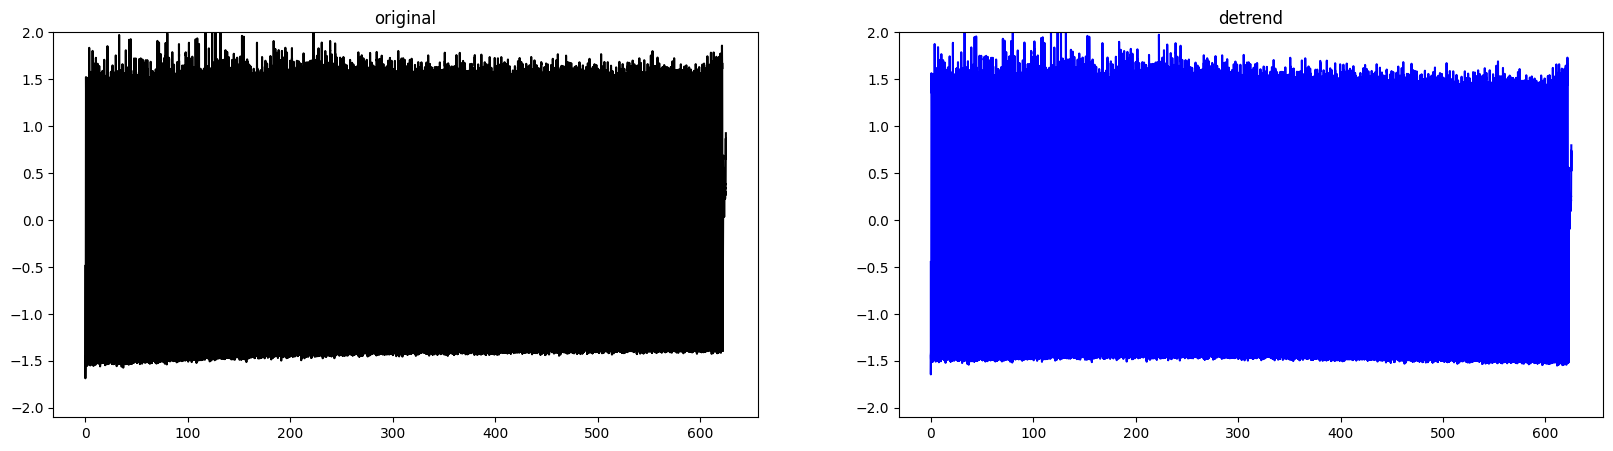

In [17]:
def detrend_all_cols(df):
    # remove linear trend in data
    
    # list data columns (neither index nor time)
    data_cols =  ['x_left','y_left','z_left','x_right','y_right','z_right']
    non_data_cols = list(df)
    for data_col in data_cols: 
        non_data_cols.remove(data_col) 
    
    detrend_df = pd.DataFrame()
    for data_col in data_cols: 
        detrend_df[data_col]=signal.detrend(np.array(df[data_col]),
                                             type='linear')
        # remove offset, to keep in the same range as beginning of series
        detrend_df[data_col]=detrend_df[data_col]-detrend_df[data_col].quantile(.01)+ df[data_col].quantile(.01)
    
    # add non_data columns
    detrend_df[non_data_cols] = df[non_data_cols]
    
    return detrend_df

# test
treadmill_data='treadmill_participant_1_order_1_21_06_15_10_04_data.csv'
cols = ['time','x_left','y_left','z_left','x_right','y_right','z_right']
treadmill_data = pd.read_csv('data/'+treadmill_data)
treadmill_data[cols] = treadmill_data[cols].apply(pd.to_numeric)

rs_data = resample_all_cols(treadmill_data)
d_data = detrend_all_cols(rs_data)
print(list(d_data))

x = np.array(rs_data['z_left'])
t = np.array(rs_data['time'])
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,2,1)
plt.plot(t/1000,x,'k')
plt.title('original')
plt.ylim([-2.1,2.0])
ax = fig.add_subplot(1,2,2)
x = np.array(d_data['z_left'])
t = np.array(d_data['time'])
plt.plot(t/1000,x,'b')
plt.title('detrend')
plt.ylim([-2.1,2.0])    

#### Attribute repeat number to each sound

In [18]:
def attribute_repeat_number_to_sound (data):
    repeat_index = np.zeros(len(data.pitch), dtype=int)
    
    repeat_index[0] = 1
    for index,(pitch,prev_pitch) in enumerate(zip(data.pitch.values[1:],data.pitch.values[:-1])):
        if pitch!=prev_pitch:
            repeat_index[index+1]=1
        else:
            repeat_index[index+1]=repeat_index[index]+1
    data['repeat_index']=repeat_index

sound_data='treadmill_participant_10_order_4_21_06_18_10_14_sound.csv'
sound_data = pd.read_csv('data/'+sound_data)
sound_data.pitch = sound_data.pitch.apply(pd.to_numeric)

attribute_repeat_number_to_sound(sound_data)

#### Segment individual steps

##### Segmentation

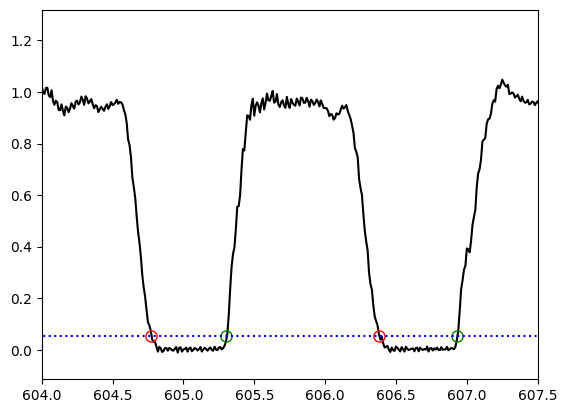

In [19]:
# find start and stop times for each step in time series x
# minduration in sec.
def segment_steps(times,x, min_duration):
    start_times = []
    end_times = []
    
    # adapt threshold to min + a percent of (range of x)
    x_min = np.percentile(x,1) 
    x_max = np.percentile(x,99)
    percent_range = 0.05
    threshold = x_min + (x_max-x_min)*percent_range
    
    # detect up and down crossings     
    mask = np.diff(1*(x > threshold)) # 1 if crosses threshold up, -1 if crosses down
    start_times = times[:-1][mask>0] 
    end_times = times[:-1][mask<0] 
    
    # drop potential endings that occur before first start
    end_times = [end_time for end_time in list(end_times) if end_time > list(start_times)[0]]
    # drop potential starts that occur after the last ending
    start_times = [start_time for start_time in list(start_times) if start_time < list(end_times)[-1]]
        
    # eliminate false alarms (ie. consecutive starts or stops within a short time window, ex. 0.1s)
    start_times, end_times = zip(*[(start_time,end_time) for start_time,end_time in zip(start_times,end_times) if (end_time-start_time) > (min_duration*1000)])
    
    return start_times, end_times, threshold

#test    
weight_data='treadmill_participant_1_21_06_15_10_04_weight.csv'
cols = ['time','x_left','y_left','z_left','x_right','y_right','z_right']
weight_data = pd.read_csv('data/'+weight_data)
weight_data[cols] = weight_data[cols].apply(pd.to_numeric)
left_weight,left_zero,right_weight,right_zero = extract_weight(weight_data)

treadmill_data='treadmill_participant_1_order_1_21_06_15_10_04_data.csv'
cols = ['time','x_left','y_left','z_left','x_right','y_right','z_right']
treadmill_data = pd.read_csv('data/'+treadmill_data)
treadmill_data[cols] = treadmill_data[cols].apply(pd.to_numeric)

norm_df = normalize_by_weight(treadmill_data,left_weight,left_zero,right_weight,right_zero)

rs_step_data = resample_all_cols(norm_df,sr,100)
de_step_data = detrend_all_cols(rs_step_data)

times = de_step_data.time
x = de_step_data.z_left
start_times, end_times, threshold = segment_steps(times,x, 0.1)
plt.plot(times/1000, x, 'k')
plt.plot(np.array(start_times)/1000,[threshold]*len(start_times), 'go', markersize=8, markerfacecolor='None')
plt.plot(np.array(end_times)/1000,[threshold]*len(end_times), 'ro', markersize=8, markerfacecolor='None')
plt.plot([times.min()/1000,times.max()/1000],[threshold,threshold],'b:')
plt.xlim([604,607.5])

plt.savefig('./pics/segmentation.pdf', format='pdf', dpi=600, transparent=True)

##### List individual steps in a Dataframe

In [20]:
def convert_to_steps(treadmill_data, min_duration=0.1):
# segment left steps from z_left, and right steps from z_right
# and list all steps (tagged as left/right) in a new dataframe

    # list data columns (neither index nor time)
    data_cols =  ['x_left','y_left','z_left','x_right','y_right','z_right']
    non_data_cols = list(treadmill_data)
    for data_col in data_cols: 
        non_data_cols.remove(data_col)
    non_data_cols.remove('time')
        
    # segment steps from each foot
    foots = ['left','right']
    foot_features = ['z_left','z_right']
    dimensions = ['x','y','z']
    
    # grow dataframe of steps 
    dataframe_cols = defaultdict(list) # dictionary of {col: list of values}
    for (foot,foot_feature) in zip(foots, foot_features): 
        
        # extract start and end times for current foot, using foot_feature
        start_times, end_times, threshold = segment_steps(treadmill_data.time,
                                                          treadmill_data[foot_feature],
                                                          min_duration=min_duration)
        
        # for each step, extract treadmill data along all dimensions (x,y,z)
        for start_time,end_time in zip(start_times,end_times): 
 
            for dimension in dimensions: 
                feature = '%s_%s'%(dimension,foot) # ex. x_left 
                step_data_for_dimension = list(treadmill_data[(treadmill_data.time >=start_time)&(treadmill_data.time <end_time)][feature])
                dataframe_cols[dimension].append(step_data_for_dimension)
            
            dataframe_cols['start'].append(start_time/1000) # time in secs
            dataframe_cols['end'].append(end_time/1000) # time in secs
            dataframe_cols['foot'].append(foot)
            
    steps = pd.DataFrame(dataframe_cols)
    
    steps[non_data_cols] = treadmill_data[non_data_cols]
    
    return steps

treadmill_data='treadmill_participant_1_order_1_21_06_15_10_04_data.csv'
cols = ['time','x_left','y_left','z_left','x_right','y_right','z_right']
treadmill_data = pd.read_csv('data/'+treadmill_data)
treadmill_data[cols] = treadmill_data[cols].apply(pd.to_numeric)
rs_treadmill_data = resample_all_cols(treadmill_data)
de_treadmill_data = detrend_all_cols(rs_treadmill_data)
steps = convert_to_steps(de_treadmill_data)

##### Merge with sound events

In [21]:
def merge_step_data_with_sounds(step_data,sound_data): 
# take df of individual steps (with start and end_times, and treadmill data as lists) 
# and join on sound events where sound.time is in [start,end]
# uses a sql join (because pandas doesn't join on >= and <=), and for this convert list columns to strings

    # convert data columns to str for the SQL operation
    dimensions = ['x','y','z']
    step_data[dimensions] = step_data[dimensions].applymap(str)
    
    sound_data['sound_id']= sound_data.index
    
    query = """
    SELECT step_data.*, sound_data.*
    FROM sound_data INNER JOIN step_data
    ON (sound_data.time >= step_data.start AND sound_data.time < step_data.end)
    ORDER BY sound_data.time
    """
    mixed_data = sqldf(query, locals())
    
    # convert back to list of float
    for dimension in dimensions: 
        mixed_data[dimension]=mixed_data[dimension].apply(lambda row: [float(d) for d in row[1:-1].split(',')]  )
    
    # remove duplicated (categorical) columns
    mixed_data = mixed_data.loc[:,~mixed_data.columns.duplicated()]
    
    return mixed_data

treadmill_data='treadmill_participant_10_order_4_21_06_18_10_14_data.csv'
cols = ['time','x_left','y_left','z_left','x_right','y_right','z_right']
treadmill_data = pd.read_csv('data/'+treadmill_data)
treadmill_data[cols] = treadmill_data[cols].apply(pd.to_numeric)
rs_treadmill_data = resample_all_cols(treadmill_data)
de_treadmill_data = detrend_all_cols(rs_treadmill_data)
step_data = convert_to_steps(de_treadmill_data)
sound_data='treadmill_participant_10_order_4_21_06_18_10_14_sound.csv'
sound_data = pd.read_csv('data/'+sound_data)
sound_data.pitch = sound_data.pitch.apply(pd.to_numeric)

merged_data = merge_step_data_with_sounds(step_data,sound_data)



##### Compute step phase

Some steps are attributed to two or more sound events, which suggests that participants vary in either their ability to synchronize with the beat, or have varying strategies to synhronize (e.g. taking sounds as a trigger to alternate steps). To understand more about this variability, we compute step phase, i.e. what time step onsets occur within the ISI. 

In [129]:
treadmill_data='treadmill_participant_2_order_1_21_06_15_10_51_data.csv'
cols = ['time','x_left','y_left','z_left','x_right','y_right','z_right']
treadmill_data = pd.read_csv('data/'+treadmill_data)
treadmill_data[cols] = treadmill_data[cols].apply(pd.to_numeric)
rs_treadmill_data = resample_all_cols(treadmill_data)
de_treadmill_data = detrend_all_cols(rs_treadmill_data)
step_data = convert_to_steps(de_treadmill_data)

sound_data='treadmill_participant_2_order_1_21_06_15_10_51_sound.csv'
sound_data = pd.read_csv('data/'+sound_data)
sound_data.pitch = sound_data.pitch.apply(pd.to_numeric)

merged_data = merge_step_data_with_sounds(step_data,sound_data)

In [130]:
def compute_sound_isi(data): 
    
    data['prev_sound_id'] = data['sound_id'] -1
    data = data.merge(data[['sound_id','time']].set_index('sound_id'), 
                      left_on='prev_sound_id', 
                      right_on='sound_id', 
                     suffixes=('', '_prev')).reset_index()
    data['sound_isi'] = data['time']-data['time_prev']
    return data

merged_data = compute_sound_isi(merged_data)
    

In [132]:
merged_data['step_phase'] = (merged_data.start - merged_data.time)/(merged_data.time - merged_data.time_prev)

In [134]:
merged_data[['foot','start','end','time','time_prev','step_phase']]

,foot,start,end,time,time_prev,step_phase
0,left,1.150002,2.030002,1.630128,0.819245,-0.592103
1,right,1.850002,2.880002,2.440524,1.630128,-0.728684
2,left,2.650002,3.560002,3.254339,2.440524,-0.742598
3,right,3.390002,4.330002,4.060480,3.254339,-0.831713
4,left,4.150002,5.070002,4.869146,4.060480,-0.889297
...,...,...,...,...,...,...
1390,right,605.770002,606.850002,606.631952,605.820203,-1.061843
1391,left,606.600002,607.670002,607.440176,606.631952,-1.039531
1392,left,606.600002,607.670002,607.440176,606.631952,-1.039531
1393,right,607.420002,608.460002,607.440176,606.631952,-0.024962


In [ ]:



def compute_step_phase(merged_data): 
# take df of individual steps merged with co-located sound_id
# returns df with step phase within previous sound cycle, i.e. how far between sound_id i-1 and sound_i is start time for step i

    
    merged_data['step_phase']



    return mixed_data

##### Delete duplicates

Some steps are attributed to two or more sound events, e.g. when the next sound starts before the previous step ends. Here, we simply drop (step,sound event) pairs for sound_id duplicates. A more advanced method would e.g. attribute the sound event to the step which has the least distance between sound.time and step.start. 

<mark> Wrong: what we have is several steps associated to the same sound, instead of several sounds associated to the same step.  We remove duplicates on `sound_id`, i.e. consecutive steps that are associated to the same sound.  

In [105]:
treadmill_data='treadmill_participant_2_order_1_21_06_15_10_51_data.csv'
cols = ['time','x_left','y_left','z_left','x_right','y_right','z_right']
treadmill_data = pd.read_csv('data/'+treadmill_data)
treadmill_data[cols] = treadmill_data[cols].apply(pd.to_numeric)
rs_treadmill_data = resample_all_cols(treadmill_data)
de_treadmill_data = detrend_all_cols(rs_treadmill_data)
step_data = convert_to_steps(de_treadmill_data)

sound_data='treadmill_participant_2_order_1_21_06_15_10_51_sound.csv'
sound_data = pd.read_csv('data/'+sound_data)
sound_data.pitch = sound_data.pitch.apply(pd.to_numeric)

merged_data = merge_step_data_with_sounds(step_data,sound_data)

#duplicates = merged_data.duplicated(subset ="sound_id", keep = False)
#duplicates = merged_data[duplicates]

#merged_data.drop_duplicates(subset ="sound_id", keep = False, inplace=True)

(450.0, 500.0)

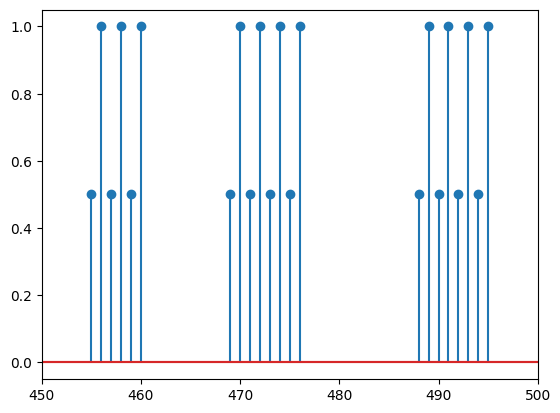

In [104]:
for index, step in enumerate(['left','right']): 
    steps = duplicates[(duplicates.foot==step)].index.to_list()
    plt.stem(steps, 0.5*(index+1)*np.ones(len(steps)))
plt.xlim([450,500])

#### Extract step duration and amplitude

<Axes: >

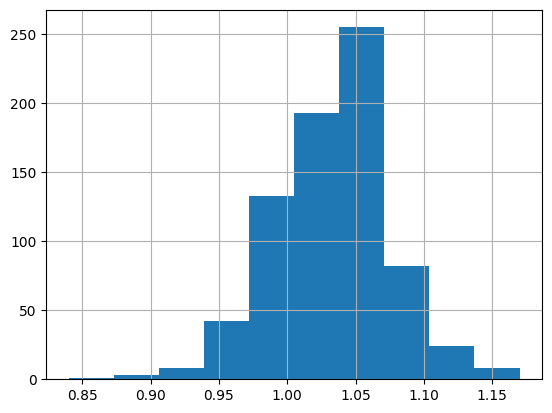

In [29]:
def extract_step_duration(step_data): 

    step_data['step_duration'] = step_data['end'] - step_data['start']
    
    return step_data
        
treadmill_data='treadmill_participant_1_order_1_21_06_15_10_04_data.csv'
cols = ['time','x_left','y_left','z_left','x_right','y_right','z_right']
treadmill_data = pd.read_csv('data/'+treadmill_data)
treadmill_data[cols] = treadmill_data[cols].apply(pd.to_numeric)
rs_treadmill_data = resample_all_cols(treadmill_data)
de_treadmill_data = detrend_all_cols(rs_treadmill_data)
step_data = convert_to_steps(de_treadmill_data)

sound_data='treadmill_participant_1_order_1_21_06_15_10_04_sound.csv'
sound_data = pd.read_csv('data/'+sound_data)
sound_data.pitch = sound_data.pitch.apply(pd.to_numeric)

merged_data = merge_step_data_with_sounds(step_data,sound_data)

extract_step_duration(merged_data)
merged_data.step_duration.hist()

In [30]:
def extract_maximum_amplitude(step_data): 

    dimensions = ['x','y','z']
    for dimension in dimensions: 
        step_data[dimension+'_max'] = step_data[dimension].apply(lambda row: np.max(row))
        step_data[dimension+'_min'] = step_data[dimension].apply(lambda row: np.min(row))
        
    return step_data

weight_data='treadmill_participant_1_21_06_15_10_04_weight.csv'
weight_data = pd.read_csv('data/'+weight_data)
weight_data[cols] = weight_data[cols].apply(pd.to_numeric)
left_weight,left_zero,right_weight,right_zero = extract_weight(weight_data)

treadmill_data='treadmill_participant_1_order_1_21_06_15_10_04_data.csv'
cols = ['time','x_left','y_left','z_left','x_right','y_right','z_right']
treadmill_data = pd.read_csv('data/'+treadmill_data)
treadmill_data[cols] = treadmill_data[cols].apply(pd.to_numeric)

norm_df = normalize_by_weight(treadmill_data,left_weight,left_zero,right_weight,right_zero)
rs_treadmill_data = resample_all_cols(norm_df)
de_treadmill_data = detrend_all_cols(rs_treadmill_data)
step_data = convert_to_steps(de_treadmill_data)

sound_data='treadmill_participant_1_order_1_21_06_15_10_04_sound.csv'
sound_data = pd.read_csv('data/'+sound_data)
sound_data.pitch = sound_data.pitch.apply(pd.to_numeric)
merged_data = merge_step_data_with_sounds(step_data,sound_data)

extract_maximum_amplitude(merged_data)
merged_data.z_max.describe()

count    749.000000
mean       1.041002
std        0.041485
min        0.948921
25%        1.011890
50%        1.033703
75%        1.064540
max        1.254101
Name: z_max, dtype: float64

#### All processing in one function

In [31]:
def process_data(treadmill_data, weight_data, sound_data, config_data, verbose = True): 
   
    # load data and convert to numeric
    if verbose: 
        print('load - ',end='')
    
    cols = ['time','x_left','y_left','z_left','x_right','y_right','z_right']
    weight_data = pd.read_csv(weight_data)
    weight_data[cols] = weight_data[cols].apply(pd.to_numeric)
    
    treadmill_data = pd.read_csv(treadmill_data)
    treadmill_data[cols] = treadmill_data[cols].apply(pd.to_numeric)
    
    sound_data = pd.read_csv(sound_data)
    sound_data.pitch = sound_data.pitch.apply(pd.to_numeric)
    
    # add repeat nnumber of each sound
    attribute_repeat_number_to_sound(sound_data)
    
    if verbose: 
        print('extract weight ',end='')
    left_weight,left_zero,right_weight,right_zero = extract_weight(weight_data)
    if verbose: 
        print('(left: [%.2f,%.2f], '%(left_zero,left_weight), end='')
        print('right: [%.2f,%.2f]) - '%(right_zero,right_weight), end='')
        
    if verbose: 
        print('preprocess - ',end='')
    norm_treadmill_data = normalize_by_weight(treadmill_data,left_weight,left_zero,right_weight,right_zero)
     
    
    rs_treadmill_data = resample_all_cols(norm_treadmill_data)
    de_treadmill_data = detrend_all_cols(rs_treadmill_data)
        
    # segment and merge
    if verbose: 
        print('segment ',end='')
    step_data = convert_to_steps(de_treadmill_data)
    if verbose: 
        print('(%d steps) - '%len(step_data),end='')
    
    if verbose: 
        print('merge with sounds ',end='')
    data = merge_step_data_with_sounds(step_data,sound_data)
    
    
    
    # delete steps for which there is ambiguity of which sound they correspond to
    duplicates = merged_data.duplicated(subset ="sound_id", keep = False)
    
    data.drop_duplicates(subset ="sound_id", keep = False, inplace=True) 
    if verbose: 
        print('(%d trials) - '%len(data),end='')

    
    # extract features
    if verbose: 
        print('extract features ',end='')
    extract_step_duration(data)
    extract_maximum_amplitude(data)
        
    
    if verbose: 
        print('left: [%.2f, %.2f], '%(data[data.foot=='left'].z_min.mean(),
                                     data[data.foot=='left'].z_max.mean()),end='')
        print('right: [%.2f, %.2f])'%(data[data.foot=='right'].z_min.mean(),
                                     data[data.foot=='right'].z_max.mean()),end='')
    
    return data, duplicates


data_t,duplicates = process_data(treadmill_data='data/treadmill_participant_1_order_1_21_06_15_10_04_data.csv',
                     weight_data='data/treadmill_participant_1_21_06_15_10_04_weight.csv',
                     sound_data='data/treadmill_participant_1_order_1_21_06_15_10_04_sound.csv',
                     config_data='data/treadmill_participant_1_order_1_21_06_15_10_04_config_sound_player_cont_narrow.py')


load - extract weight (left: [-1.50,1.48], right: [-0.03,2.71]) - preprocess - segment (769 steps) - merge with sounds (749 trials) - extract features left: [0.04, 1.05], right: [0.03, 1.03])

### Prepare all data

List all sessions (participant, block) in data directory, and link with all needed files

In [32]:
# organize files per participants
def parse_participant(file): 
    return int(file.split('_')[2])

def parse_block(file): 
    return int(file.split('_')[4])

def parse_date(file): 
    return datetime.strptime('-'.join(file.split('_')[5:10]), '%d-%m-%y-%H-%M').strftime('%d/%m/%Y')

def find_sound_file(participant,block): 
    files = glob.glob('data/treadmill_participant_%d_order_%d_*_sound.csv'%(participant,block))
    return files[0]

def find_weight_file(participant): 
    files = glob.glob('data/treadmill_participant_%d_*_weight.csv'%(participant))
    return files[0]

def find_config_file(participant,block): 
    files = glob.glob('data/treadmill_participant_%d_order_%d_*_config_*.py'%(participant,block))
    return files[0]

# list sessions {participant id, block, date} from data_files
data_files = glob.glob('data/*_data.csv')
sessions = []
for file_index,data_file in enumerate(data_files):
    
    session = {'participant':parse_participant(data_file),
               'block':parse_block(data_file),
               'date':parse_date(data_file),
               'data':data_file}
    
    # add corresponding sound file
    session['sounds']=find_sound_file(session['participant'],session['block'])
    # add weights
    session['weights']=find_weight_file(session['participant'])
    # add config file and parameters
    session['config']=find_config_file(session['participant'],session['block'])
     
    sessions.append(session)

sessions_df = pd.DataFrame(sessions)
sessions_df

,participant,block,date,data,sounds,weights,config
0,10,1,21/06/2018,data\treadmill_participant_10_order_1_21_06_18...,data\treadmill_participant_10_order_1_21_06_18...,data\treadmill_participant_10_21_06_18_10_14_w...,data\treadmill_participant_10_order_1_21_06_18...
1,10,2,21/06/2018,data\treadmill_participant_10_order_2_21_06_18...,data\treadmill_participant_10_order_2_21_06_18...,data\treadmill_participant_10_21_06_18_10_14_w...,data\treadmill_participant_10_order_2_21_06_18...
2,10,3,21/06/2018,data\treadmill_participant_10_order_3_21_06_18...,data\treadmill_participant_10_order_3_21_06_18...,data\treadmill_participant_10_21_06_18_10_14_w...,data\treadmill_participant_10_order_3_21_06_18...
3,10,4,21/06/2018,data\treadmill_participant_10_order_4_21_06_18...,data\treadmill_participant_10_order_4_21_06_18...,data\treadmill_participant_10_21_06_18_10_14_w...,data\treadmill_participant_10_order_4_21_06_18...
4,11,1,21/06/2018,data\treadmill_participant_11_order_1_21_06_18...,data\treadmill_participant_11_order_1_21_06_18...,data\treadmill_participant_11_21_06_18_11_12_w...,data\treadmill_participant_11_order_1_21_06_18...
...,...,...,...,...,...,...,...
75,8,4,21/06/2016,data\treadmill_participant_8_order_4_21_06_16_...,data\treadmill_participant_8_order_4_21_06_16_...,data\treadmill_participant_8_21_06_16_11_52_we...,data\treadmill_participant_8_order_4_21_06_16_...
76,9,1,21/06/2017,data\treadmill_participant_9_order_1_21_06_17_...,data\treadmill_participant_9_order_1_21_06_17_...,data\treadmill_participant_9_21_06_17_13_13_we...,data\treadmill_participant_9_order_1_21_06_17_...
77,9,2,21/06/2017,data\treadmill_participant_9_order_2_21_06_17_...,data\treadmill_participant_9_order_2_21_06_17_...,data\treadmill_participant_9_21_06_17_13_13_we...,data\treadmill_participant_9_order_2_21_06_17_...
78,9,3,21/06/2017,data\treadmill_participant_9_order_3_21_06_17_...,data\treadmill_participant_9_order_3_21_06_17_...,data\treadmill_participant_9_21_06_17_13_13_we...,data\treadmill_participant_9_order_3_21_06_17_...


In [49]:
sessions_df[(sessions_df.participant==2)&(sessions_df.block==1)].data.loc[48]

'data\\treadmill_participant_2_order_1_21_06_15_10_51_data.csv'

In [66]:
all_session_data = []
for index, session in sessions_df.sort_values(by='participant').iterrows():

    print('Participant %d, block %d: \n'%(session['participant'],session['block']), end='')
    # process session data into dataframe of trials
    session_data_df = process_data(treadmill_data = session['data'],
                                   weight_data = session['weights'],
                                   sound_data = session['sounds'],
                                   config_data = session['config'],
                                   verbose=True)
    print(' -> %d trials\n'%len(session_data_df))
    all_session_data.append(session_data_df)

data = pd.concat(all_session_data)


Participant 1, block 4: 
load - extract weight (left: [-1.50,1.48], right: [-0.03,2.71]) - preprocess - segment (752 steps) - merge with sounds (749 trials) - extract features left: [0.13, 1.11], right: [0.08, 1.05]) -> 749 trials

Participant 1, block 3: 
load - extract weight (left: [-1.50,1.48], right: [-0.03,2.71]) - preprocess - segment (753 steps) - merge with sounds (749 trials) - extract features left: [0.10, 1.09], right: [0.06, 1.04]) -> 749 trials

Participant 1, block 1: 
load - extract weight (left: [-1.50,1.48], right: [-0.03,2.71]) - preprocess - segment (769 steps) - merge with sounds (749 trials) - extract features left: [0.04, 1.05], right: [0.03, 1.03]) -> 749 trials

Participant 1, block 2: 
load - extract weight (left: [-1.50,1.48], right: [-0.03,2.71]) - preprocess - segment (753 steps) - merge with sounds (749 trials) - extract features left: [0.07, 1.07], right: [0.04, 1.03]) -> 749 trials

Participant 2, block 2: 
load - extract weight (left: [-1.12,0.27], righ

load - extract weight (left: [-2.46,-1.16], right: [-0.75,0.43]) - preprocess - segment (765 steps) - merge with sounds (325 trials) - extract features left: [0.11, 1.12], right: [0.04, 1.02]) -> 325 trials

Participant 18, block 4: 
load - extract weight (left: [-2.46,-1.16], right: [-0.75,0.43]) - preprocess - segment (762 steps) - merge with sounds (301 trials) - extract features left: [0.13, 1.14], right: [0.06, 1.04]) -> 301 trials

Participant 19, block 2: 
load - extract weight (left: [-1.25,-0.05], right: [-0.63,0.41]) - preprocess - ABNORMAL z_left VALUE AFTER NORM: -0.824895,1.267932
ABNORMAL z_right VALUE AFTER NORM: -0.039216,2.235294
segment (753 steps) - merge with sounds (726 trials) - extract features left: [0.05, 1.05], right: [0.05, 1.03]) -> 726 trials

Participant 19, block 3: 
load - extract weight (left: [-1.25,-0.05], right: [-0.63,0.41]) - preprocess - ABNORMAL z_left VALUE AFTER NORM: -0.810127,1.295359
ABNORMAL z_right VALUE AFTER NORM: 0.000000,2.254902
segme

In [67]:
# add musical score to treadmill data
data = data.merge(answers_msi[['participant','age','gender','musician','musical_score']],
                      left_on = 'participant',
                      right_on = 'participant',
                      how='left',
                     suffixes=['','_msi']) 
# passer les données dans un nouveau fichier texte ?

In [68]:
data = data.reset_index().rename(columns={"index": "trial_index"})

The complete datasets includes several configurations, using only original recordings or using all pitch-shifted recordings, using notes from 2 octaves or 5 octaves, and using isolated or repeated notes. In the following, we only analyse data from the `cont_narrow_repeat_3` configuration, which corresponds to notes extracted from octaves 4 and 5, including all pitch shifted versions, and each successive note repeated three consecutive times. 

In [69]:
data.groupby(['condition_name']).agg({'note':['min','max'], 'sound_id':'nunique','pitch':'nunique'})

note      sound_id   pitch
                        min  max  nunique nunique
condition_name                                   
cont_narrow_1            A4  Gb5      749     252
cont_narrow_repeat_3     A4  Gb5      749     249
discret_large_1          A2  Gb6      750      71
discret_large_repeat_3   A2  Gb6      749      71

In [70]:
data = data[data.condition_name =='cont_narrow_repeat_3']

### Remove outliers

This procedure results in an average M=668 trials per participant (min=403, max=750, SD=114), each associating the time-series of a single step and the characteristics of the corresponding musical note.

In [71]:
data.groupby(['participant']).sound_id.count().apply(['min','max','mean','std'])

min     403.000000
max     749.000000
mean    668.650000
std     114.535802
Name: sound_id, dtype: float64

We removed participants who had more than 20% steps not associated with sounds. 

In [89]:
thresh=0.2
data['nb_trials'] = data.groupby(['participant']).sound_id.transform("count")
data.loc[:,'outlier_status'] = data.nb_trials < 750*(1-thresh)
print("%d participants left in analysis (%d removed)"%(data[data.outlier_status==False].participant.nunique(),
                                                       data[data.outlier_status==True].participant.nunique()))

14 participants left in analysis (0 removed)


In [73]:
data[data.outlier_status==True].groupby(['gender','musician']).participant.nunique()

gender  musician
F       non         1
        oui         2
M       non         2
        oui         1
Name: participant, dtype: int64

In [74]:
data[data.outlier_status==False].to_csv('data/data.csv')

### Data-driven analysis

While previous work has focused on quantifying step data based on predefined characteristics (such as step and stride length, or heel and toe contact force), and contrast them along predefined stimulus properties (such as consonance), we use here a data-driven strategy in which we let regions showing significant associations with sound emerge from an \emph{a-posteriori} analysis of participant responses to many, systematically-varied sounds. 

In more details, we use a method inspired by the psychophysical technique of "classification images" . For each participant $k$, we compute a kernel $\tilde{p}_k(t)$ obtained by multiplying the time series of each the participant's $n$ steps $p_i(t)$ (with $t\in[0,100]$ for a 1-sec step sampled at 100Hz) by a weighting factor $z_i$ corresponding to the z-score of the log-transformed pitch of the corresponding note, and then averaging these weighted time-series over all $n$ steps: 
$\tilde{p}_k(t)=\Sigma_{i=1}^{n} p_{i}^{k}(t)z_i$. Doing so, we weight negatively the patterns of step data that are associated with sound events with lower-than-average pitch, and positively weight those associated with high pitch. The resulting kernel $\tilde{p}_k(t)$ is itself a time-series analog to a single step, which represents the strength of statistical association between step force and musical pitch, as a function of time. We test the statistical significance of this association with a one-sample ttest comparison to zero at each time point. 


#### Melt time series as successive (t,v) rows for each step

In [2]:
def melt_time_series (data_in, 
                      feature='z',
                     normalize_time=True,
                     z_score=False): 
    
    QUANT = .99
    columns = {}
    
    data = data_in.copy()
    
    # convert x,y,z string representations to lists (by evaluating them as literals)
    data[feature] = data[feature].apply(lambda row: ast.literal_eval(row))
    
    if z_score: 
        data[feature] = data[feature].apply(lambda x: (x-np.nanmean(x))/np.nanstd(x))

    data['relative_time'] = (data.time - data.start)/data.step_duration # location of sound in % step duration

    # remove all steps larger than QUANT quantile
    length_col = 'len_'+feature+'_value'
    data[length_col] = data[feature].apply(len)
    maximum_length = data[length_col].quantile(QUANT)
    data = data[data[length_col] <= maximum_length]
    
    if normalize_time: 
        NORM_LENGTH = 100 
        # normalize x,y,z to 100
        data[feature] = data.apply(lambda row: signal.resample(row[feature],NORM_LENGTH), axis=1)
        maximum_length = NORM_LENGTH
                               
    else: 
        # pad x,y,z to maximum_length
        data[feature] = data.apply(lambda row: np.pad(row[feature],
                                                      (0, int(maximum_length-row[length_col])),
                                                      'constant',constant_values=np.nan), axis=1)
    
    # create dataframe with series data as columns
    for i in np.arange(maximum_length): 
        columns['%s_%d'%(feature,i)]= np.stack(data[feature].to_numpy())[:,int(i)]
    df = pd.DataFrame(columns)

    # merge with data
    data = pd.concat([data.reset_index(drop=True),df], axis=1)

    # melt series data columns as lines (t,value)
    value_vars = [feature+'_%d'%i for i in np.arange(maximum_length)]
    id_vars = [x for x in list(data) if (x not in value_vars)]
    data = pd.melt(data, 
                   id_vars=id_vars, 
                   value_vars=value_vars,
                   var_name='t',
                   value_name=feature+'_value')

    # reformat t as integer (z_32 -> 32)
    data.t = data.t.apply(lambda v: int(v.split('_')[1]))
    
    return data

#### Compute classification images

In [3]:
zscore = lambda x: (x-np.nanmean(x))/np.nanstd(x)

def compute_classification_image(data, 
                                 feature='z_value',
                                 criteria = 'log_pitch'): 
    
    kernels = data.copy()
    
    # compute classification image
    # normalize musical pitch
    kernels['norm_criteria'] = kernels.groupby(['participant'])[criteria].transform(zscore)
    # ponderate times series with criteria
    kernels['gain'] = (kernels[feature] * kernels.norm_criteria)
    
    return kernels

In [4]:
def compute_one_sample_stats(kernels): 
    
    stats = []
    for t in kernels.t.unique():
        sample = kernels[kernels.t==t].gain # all kernel gains at that time
        # if length is not normalized, and for high-t's, we may have samples witha  single point (and the rest of NaNs)
        if np.count_nonzero(~np.isnan(sample))>1: # test that sample > 1
            stats += [pg.ttest(sample,0).loc['T-test',['p-val','T','dof']]] # one-sample difference to zero
            
    # display time steps where stat is significant
    all_stats = [(t,cell) for t,cell in enumerate(stats)]
    sig_t = [(t,cell) for t,cell in enumerate(stats) if cell['p-val']<=0.05]
    #for t,cell in sig_t:
    #    print('- %d: t(%d)=%.2f, p=%.3f'%(t+offset,cell['dof'],cell['T'],cell['p-val']))
    return all_stats, sig_t
            

In [5]:
def compute_two_sample_stats(kernels1, kernels2): 
    
    stats = []
            
    for t in kernels1.t.unique():
        sample_1 = kernels1[kernels1.t==t].gain
        sample_2 = kernels2[kernels2.t==t].gain                
        if (np.count_nonzero(~np.isnan(sample_1))>1) & (np.count_nonzero(~np.isnan(sample_2))>1): # test that both samples > 1
            stats += [pg.ttest(sample_1,sample_2,paired=False).loc['T-test',['p-val','T','dof']]]
            
    all_stats = [(t,cell) for t,cell in enumerate(stats)]
    sig_t = [(t,cell) for t,cell in enumerate(stats) if cell['p-val']<=0.05]
    # for t,cell in sig_t:
    #     print('- %d: t(%d)=%.2f, p=%.3f'%(t,cell['dof'],cell['T'],cell['p-val']))
    
    return all_stats, sig_t

#### Kernel visualization

In [6]:
def plot_classification_image(kernels,
                              mean_time, 
                              stats, 
                              ylim = [-0.01, 0.01],
                              ylabel=True,
                              label = "",
                              xlabel=True,
                              legend='brief',
                              alphas=[1.0,1.0], 
                              fontsize = 40,
                              linewidth = 3):
    
    if legend:
        legend='brief'
     
    for epoch_index,epoch in enumerate(['before','after']):
        
        if(epoch=='before'):
            a = kernels[kernels.t<=mean_time]
            legend_label = label + "pre-stimulus"
        
        if(epoch=='after'):
            a = kernels[kernels.t>=mean_time]
            legend_label = label + "post-stimulus"
        
        sns.lineplot(data=a,
                     x='t',
                     y='gain',
                     palette=sns.color_palette()[epoch_index], 
                     legend=legend,
                     label = legend_label,
                     alpha=alphas[epoch_index],
                     linewidth = linewidth)        
    
        for t,cell in stats:
            if(epoch=='before'):
                if(t>=mean_time):
                    break
            if(epoch=='after'):
                if((t<=mean_time) or (t>99)):
                    continue
            plt.text(t,ylim[1]/3,'*',color=sns.color_palette()[epoch_index], fontsize=fontsize, alpha=alphas[epoch_index])
                    
    # format graph
    plt.plot([0,120],[0,0],'k:')
    plt.xlim([0,100])
    plt.xlabel('time', fontsize=fontsize)
    plt.ylim(ylim)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.ylabel('gain (a.u.)',fontsize=fontsize)
    if not xlabel:
        plt.xlabel('')
        plt.xticks([])
    if not ylabel:
        plt.ylabel('')
        plt.yticks([])
    if legend: 
        leg = plt.legend(loc=2, prop={'size': fontsize})
        for line in leg.get_lines():
            line.set_linewidth(linewidth)
            
    
    # plot mean onset time
    plt.plot([mean_time,mean_time],ylim,'k:', linewidth=linewidth)   


c:\users\aucouturier\appdata\local\programs\python\python36\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.12, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
c:\users\aucouturier\appdata\local\programs\python\python36\lib\site-packages\outdated\utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


## Results

In [7]:
data = pd.read_csv('data/data.csv', index_col=0)
data = data.reset_index(drop=True)

### Average step

Participants' step data displayed a saddle shape in the vertical and medio-lateral force dimensions and a progressive transition from anterior to posterior force, which is the expected shape for a stance including an initial, braking heel strike followed by a final propulsive 'toe off'. Step duration was stable at M=105ms (SD=71ms). Consistent with similar synchronization tasks in the literature, we found that participants' steps steadily anticipated the onset of the notes, with a mean onset time occurring M=608ms (SD=83ms) after the start of support of the corresponding step, roughly at a local minimum of antero-posterior and latero-medial forces. 

mean onset time t=608.7ms


c:\users\aucouturier\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:62: RuntimeWarning: Mean of empty slice


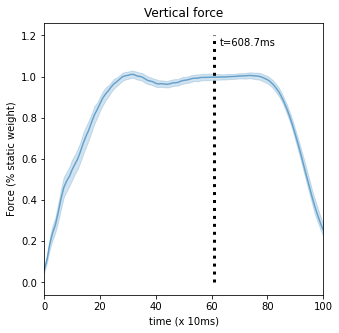

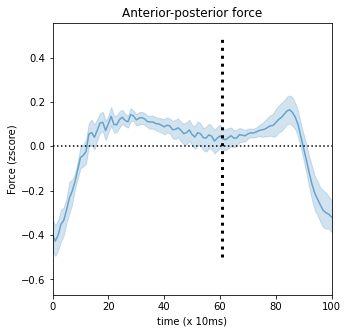

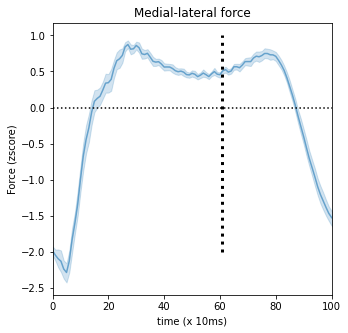

In [8]:
fig = plt.figure(figsize=(5,5))
    
z_data = melt_time_series (data_in=data, feature='z',
                         normalize_time=False) 
a = z_data.groupby(['participant','t']).agg({'z_value':np.nanmean}).reset_index()

sns.lineplot(data=a,
             x='t',
             y='z_value',
             #estimator=None,
             #units='participant', 
            alpha=0.6)
             #hue='p '+a['participant'].astype(str))
plt.title('Vertical force')
_=plt.xlabel('time (x 10ms)')
_=plt.ylabel('Force (% static weight)')
#plt.legend(loc=8, ncol=6)

mean_relative_time = z_data.groupby(['participant']).relative_time.mean().mean()
mean_duration = z_data.groupby(['participant']).step_duration.mean().mean()
mean_time = mean_relative_time * mean_duration / 0.01
print("mean onset time t=%.1fms"%(mean_time*10))
plt.text(mean_time+2,1.15, "t=%.1fms"%(mean_time*10))
plt.plot([mean_time, mean_time],[0,1.2], 'k:', linewidth=3)
plt.xlim([0,100])
plt.savefig('./pics/average_z.pdf', format='pdf', dpi=600, transparent=True)

#fig = plt.figure(figsize=(5,5))

fig = plt.figure(figsize=(5,5))
    
x_data = melt_time_series (data_in=data,
                           feature='x',
                         normalize_time=False, z_score=True) 
a = x_data.groupby(['participant','t']).agg({'x_value':np.nanmean}).reset_index()

sns.lineplot(data=a,
             x='t',
             y='x_value',
             #estimator=None,
             #units='participant', 
            alpha=0.6)
             #hue='p '+a['participant'].astype(str))
plt.title('Anterior-posterior force')
_=plt.xlabel('time (x 10ms)')
_=plt.ylabel('Force (zscore)')
#plt.ylim([-0.5,0.5])
plt.plot([mean_time, mean_time],[-0.5,0.5], 'k:', linewidth=3)
#plt.text(mean_time+2,0.4, "t=%.1fms"%(mean_time*10))

plt.plot([0,100],[0,0],'k:')
plt.xlim([0,100])
plt.savefig('./pics/average_x.pdf', format='pdf', dpi=600, transparent=True)

#fig = plt.figure(figsize=(5,5))

fig = plt.figure(figsize=(5,5))
    
y_data = melt_time_series (data_in=data, 
                         feature='y',
                         normalize_time=False, z_score=True) 
a = y_data.groupby(['participant','t']).agg({'y_value':lambda x: np.nanmean(x)}).reset_index()

sns.lineplot(data=a,
             x='t',
             y='y_value',
             #estimator=None
             #units='participant', 
            alpha=0.6)
             #hue='p '+a['participant'].astype(str))
plt.title('Medial-lateral force')
_=plt.xlabel('time (x 10ms)')
_=plt.ylabel('Force (zscore)')
plt.plot([mean_time, mean_time],[-2.0,1], 'k:', linewidth=3)
#plt.text(mean_time+2,2, "t=%.1fms"%(mean_time*10))
plt.plot([0,100],[0,0],'k:')
plt.xlim([0,100])
plt.savefig('./pics/average_y.pdf', format='pdf', dpi=600, transparent=True)


count    10280.000000
mean         0.608811
std          0.083811
min          0.061376
25%          0.560713
50%          0.601673
75%          0.653237
max          2.334120
Name: onset_time, dtype: float64

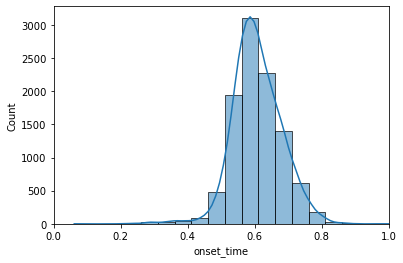

In [10]:
data['onset_time'] = (data.time - data.start)
sns.histplot(data=data, x="onset_time", kde=True, binwidth=0.05)
plt.xlim([0,1])
data.onset_time.describe()

count    10280.000000
mean         1.052416
std          0.071374
min          0.780013
25%          1.020000
50%          1.050000
75%          1.080000
max          2.750000
Name: step_duration, dtype: float64

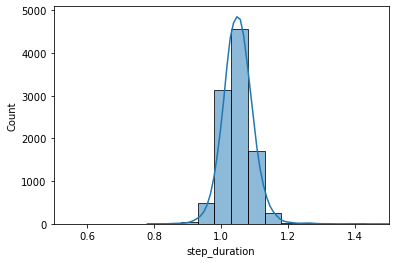

In [11]:
sns.histplot(data=data, x="step_duration", kde=True, binwidth=0.05)
plt.xlim([0.5,1.5])
data.step_duration.describe()

### Classification images - all steps

Participants' classification images showed a cluster of statistically-significant negative associations between musical pitch and vertical force from t=800 to 1000ms (t(13) $\in$ [-2.20,-3.58], all ps < .046), showing that steps that occurred on lower notes exhibited more positive vertical force in their later, propulsive phase. This cluster co-occurred with a similarly negative association in the latero-medial dimension (from t=780 to 880ms; t(13) $\in$ [-2.24,-3.71], all ps < .043), indicating a medial direction consistent with the final toe off. There was no association between musical pitch and participants' steps in the antero-posterior dimension. 

#### Vertical force - Z 

In [133]:
z_data = melt_time_series (data_in=data, feature='z',
                         normalize_time=False) 

In [134]:
kernels = compute_classification_image(z_data, 
                                 feature='z_value',
                                 criteria = 'log_pitch')

participant_kernels = kernels.groupby(['participant','t']).gain.mean().reset_index()

In [135]:
stats, sig_t = compute_one_sample_stats(participant_kernels)
for t,cell in sig_t:
    print('- %d: t(%d)=%.2f, p=%.3f'%(t,cell['dof'],cell['T'],cell['p-val']))

- 80: t(13)=-2.20, p=0.046
- 81: t(13)=-2.54, p=0.025
- 82: t(13)=-2.45, p=0.029
- 83: t(13)=-2.46, p=0.029
- 84: t(13)=-3.05, p=0.009
- 85: t(13)=-2.97, p=0.011
- 86: t(13)=-3.05, p=0.009
- 87: t(13)=-3.05, p=0.009
- 88: t(13)=-3.22, p=0.007
- 89: t(13)=-3.58, p=0.003
- 90: t(13)=-2.89, p=0.013
- 91: t(13)=-3.27, p=0.006
- 92: t(13)=-3.27, p=0.006
- 93: t(13)=-2.96, p=0.011
- 94: t(13)=-2.94, p=0.012
- 95: t(13)=-2.68, p=0.019
- 96: t(13)=-2.58, p=0.023
- 97: t(13)=-2.46, p=0.029
- 98: t(13)=-2.47, p=0.028
- 100: t(13)=-2.38, p=0.033
- 102: t(13)=-2.35, p=0.035


mean onset time t=608.7ms


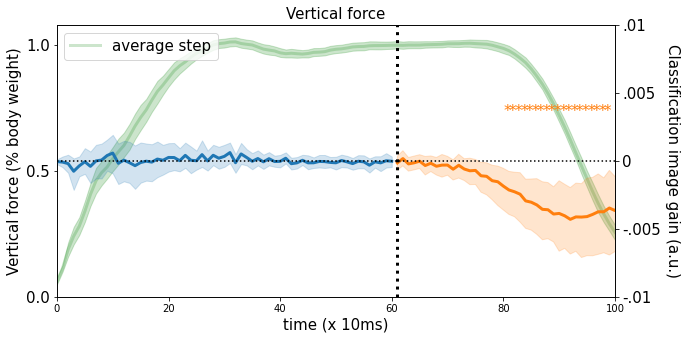

In [136]:
mean_relative_time = z_data.groupby(['participant']).relative_time.mean().mean()
mean_duration = z_data.groupby(['participant']).step_duration.mean().mean()
mean_time = mean_relative_time * mean_duration / 0.01
print("mean onset time t=%.1fms"%(mean_time*10))

fig, ax1 = plt.subplots(figsize=(10,5))

# average step
scaler = .008
a = z_data.groupby(['participant','t']).agg({'z_value':np.nanmean}).reset_index()
a.z_value = scaler * a.z_value
sns.lineplot(data=a,
             x='t',
             y='z_value',
             #estimator=None,
             #units='participant', 
            alpha=0.2, color = 'green', 
             label='average step', linewidth=3)
             #hue='p '+a['participant'].astype(str))
plt.yticks(ticks=[0,0.5*scaler,1*scaler], 
           labels=['0.0','0.5','1.0'], fontsize=15)
plt.ylabel('Vertical force (% body weight)', fontsize=15)
plt.xlabel('time (x 10ms)', fontsize=15)
plt.legend(fontsize=15)
ax1.legend(loc="upper left", fontsize=15)

# superimpose classification image
ax2 = ax1.twinx()
plot_classification_image(kernels=participant_kernels,
                         mean_time=mean_time,
                         stats=sig_t, 
                         alphas=[1,1], fontsize=15)
plt.title('Vertical force', fontsize=15)
plt.xlabel('time (x 10ms)', fontsize=15)
plt.ylabel ('Classification image gain (a.u.)', fontsize=15, rotation=270, va="bottom")
plt.yticks(ticks=[-0.01,-.005,0,.005,.01], 
           labels=['-.01', '-.005', '0', '.005', '.01'], fontsize=15)
#ax2.legend(loc="lower center", title='Classification image', fontsize=15)
ax2.get_legend().remove()


plt.savefig('./pics/kernel_z.pdf', format='pdf', dpi=600, transparent=True)


#### Anterior-posterior force - X

In [137]:
x_data = melt_time_series (data_in=data, feature='x',
                         normalize_time=False, z_score=True) 

In [138]:
kernels = compute_classification_image(x_data, 
                                 feature='x_value',
                                 criteria = 'log_pitch')

participant_kernels = kernels.groupby(['participant','t']).gain.mean().reset_index()

In [139]:
stats, sig_t = compute_one_sample_stats(participant_kernels)
for t,cell in sig_t:
    print('- %d: t(%d)=%.2f, p=%.3f'%(t,cell['dof'],cell['T'],cell['p-val']))

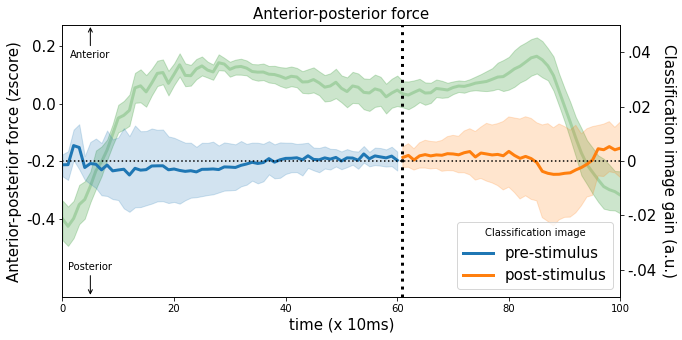

In [140]:
fig, ax1 = plt.subplots(figsize=(10,5))

# average step
scaler = .04
a = x_data.groupby(['participant','t']).agg({'x_value':np.nanmean}).reset_index()
a.x_value = scaler * a.x_value
sns.lineplot(data=a,
             x='t',
             y='x_value',
             #estimator=None,
             #units='participant', 
            alpha=0.2, color = 'green', 
             label='average step', linewidth=3)
             #hue='p '+a['participant'].astype(str))
plt.yticks(ticks=[-.4*scaler, -.2*scaler, 0*scaler, .2*scaler], 
           labels=['-0.4','-0.2','0.0','0.2'], fontsize=15)
plt.ylabel('Anterior-posterior force (zscore)', fontsize=15)
plt.xlabel('time (x 10ms)', fontsize=15)

ax1.get_legend().remove()

# superimpose classification image
ax2 = ax1.twinx()
plot_classification_image(kernels=participant_kernels,
                         mean_time=mean_time,
                         stats=sig_t, 
                         alphas=[1,1], ylim=[-0.05,0.05],fontsize=15)
plt.ylabel ('Classification image gain (a.u.)', fontsize=15, rotation=270, va="bottom")
plt.title('Anterior-posterior force', fontsize=15)
plt.xlabel('time (x 10ms)', fontsize=15)
plt.yticks(ticks=[-0.04,-.02,0,.02,.04], 
           labels=['-.04','-.02','0','.02','.04'], fontsize=15)
ax2.legend(loc="lower right", title='Classification image', fontsize=15)

plt.annotate(
# Label and coordinate
'Posterior', xy=(5, -.05),xytext=(5, -.04) ,
horizontalalignment="center",
# Custom arrow
arrowprops=dict(arrowstyle='->',lw=1)
)

plt.annotate(
# Label and coordinate
'Anterior', xy=(5, .05),xytext=(5, .038) ,
horizontalalignment="center",
# Custom arrow
arrowprops=dict(arrowstyle='->',lw=1)
)

plt.savefig('./pics/kernel_x.pdf', format='pdf', dpi=600, transparent=True)



#### Medial-lateral force - Y

In [141]:
y_data = melt_time_series (data_in=data, feature='y',
                         normalize_time=False, z_score=True) 

In [142]:
kernels = compute_classification_image(y_data, 
                                 feature='y_value',
                                 criteria = 'log_pitch')

participant_kernels = kernels.groupby(['participant','t']).gain.mean().reset_index()

In [143]:
stats, sig_t = compute_one_sample_stats(participant_kernels)
for t,cell in sig_t:
    print('- %d: t(%d)=%.2f, p=%.3f'%(t,cell['dof'],cell['T'],cell['p-val']))

- 6: t(13)=2.53, p=0.025
- 28: t(13)=-2.54, p=0.025
- 78: t(13)=-2.32, p=0.037
- 80: t(13)=-2.53, p=0.025
- 81: t(13)=-2.68, p=0.019
- 82: t(13)=-3.53, p=0.004
- 83: t(13)=-2.60, p=0.022
- 85: t(13)=-3.71, p=0.003
- 86: t(13)=-2.86, p=0.013
- 88: t(13)=-2.24, p=0.043
- 102: t(13)=2.84, p=0.014
- 104: t(13)=2.95, p=0.011
- 105: t(13)=2.55, p=0.024
- 106: t(13)=2.61, p=0.022


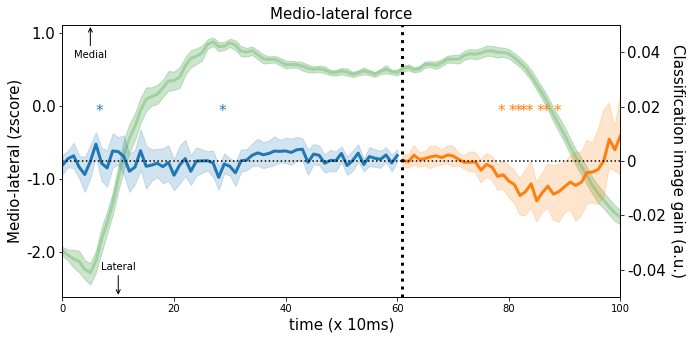

In [144]:
fig, ax1 = plt.subplots(figsize=(10,5))

# average step
scaler = .04
a = y_data.groupby(['participant','t']).agg({'y_value':np.nanmean}).reset_index()
a.y_value = scaler * a.y_value
sns.lineplot(data=a,
             x='t',
             y='y_value',
             #estimator=None,
             #units='participant', 
            alpha=0.2, color = 'green', 
             label='average step', linewidth=3)
             #hue='p '+a['participant'].astype(str))
plt.yticks(ticks=[-2*scaler, -1*scaler, 0*scaler, 1*scaler], 
           labels=['-2.0','-1.0','0.0','1.0'], fontsize=15)
plt.ylabel('Medio-lateral (zscore)', fontsize=15)
plt.xlabel('time (x 10ms)', fontsize=15)

ax1.get_legend().remove()

# superimpose classification image
ax2 = ax1.twinx()
plot_classification_image(kernels=participant_kernels,
                         mean_time=mean_time,
                         stats=sig_t, 
                         alphas=[1,1], ylim=[-0.05,0.05],fontsize=15)
plt.ylabel ('Classification image gain (a.u.)', fontsize=15, rotation=270, va="bottom")
plt.title('Medio-lateral force', fontsize=15)
plt.xlabel('time (x 10ms)', fontsize=15)
plt.yticks(ticks=[-0.04,-.02,0,.02,.04], 
           labels=[-.04,-.02,0,.02,.04], fontsize=15)
ax2.get_legend().remove()

plt.annotate(
# Label and coordinate
'Lateral', xy=(10, -.05),xytext=(10, -.04) ,
horizontalalignment="center",
# Custom arrow
arrowprops=dict(arrowstyle='->',lw=1)
)

plt.annotate(
# Label and coordinate
'Medial', xy=(5, .05),xytext=(5, .038) ,
horizontalalignment="center",
# Custom arrow
arrowprops=dict(arrowstyle='->',lw=1)
)

plt.savefig('./pics/kernel_y.pdf', format='pdf', dpi=600, transparent=True)



### Classification images - by repeats

We then grouped each participant's trials and computed separated classification images for steps that occurred on the first, second and third repetition of each note. This revealed that the above effect was driven by negative associations that occurred specifically the second and third consecutive time any given note was heard and stepped onto. In the vertical force dimension, step 2 had a significant negative cluster from t=710 to 810ms (t(13) $\in$ [-2.23,-2.99], all ps < .044) and step 3 from 810 to 1060ms (t(13) $\in$ [-2.18, -4.01], all ps < .049), but none in step 1.

#### Vertical force - Z

In [10]:
z_data = melt_time_series (data_in=data, feature='z',
                         normalize_time=False) 

mean_relative_time = z_data.groupby(['participant']).relative_time.mean().mean()
mean_duration = z_data.groupby(['participant']).step_duration.mean().mean()
mean_time = mean_relative_time * mean_duration / 0.01
print("mean onset time t=%.1fms"%(mean_time*10))

mean onset time t=608.7ms


REPEAT_INDEX =1
REPEAT_INDEX =2
- 5: t(13)=2.89, p=0.013
- 71: t(13)=-2.40, p=0.032
- 73: t(13)=-2.99, p=0.010
- 74: t(13)=-2.39, p=0.033
- 75: t(13)=-2.37, p=0.034
- 76: t(13)=-2.56, p=0.024
- 77: t(13)=-2.23, p=0.044
- 78: t(13)=-2.41, p=0.031
- 81: t(13)=-2.21, p=0.046
REPEAT_INDEX =3
- 1: t(13)=-3.12, p=0.008
- 3: t(13)=-2.27, p=0.041
- 4: t(13)=-2.87, p=0.013
- 6: t(13)=-2.25, p=0.042
- 81: t(13)=-2.79, p=0.015
- 82: t(13)=-2.34, p=0.036
- 83: t(13)=-2.58, p=0.023
- 84: t(13)=-2.62, p=0.021
- 85: t(13)=-2.31, p=0.038
- 86: t(13)=-2.17, p=0.049
- 87: t(13)=-2.40, p=0.032
- 88: t(13)=-2.37, p=0.034
- 89: t(13)=-2.32, p=0.037
- 90: t(13)=-2.18, p=0.049
- 91: t(13)=-2.38, p=0.033
- 92: t(13)=-2.41, p=0.031
- 93: t(13)=-2.43, p=0.030
- 94: t(13)=-2.54, p=0.024
- 95: t(13)=-2.69, p=0.018
- 96: t(13)=-2.68, p=0.019
- 97: t(13)=-2.72, p=0.018
- 98: t(13)=-3.37, p=0.005
- 99: t(13)=-3.20, p=0.007
- 100: t(13)=-3.23, p=0.007
- 101: t(13)=-4.01, p=0.001
- 102: t(13)=-3.74, p=0.002
- 103: t(1

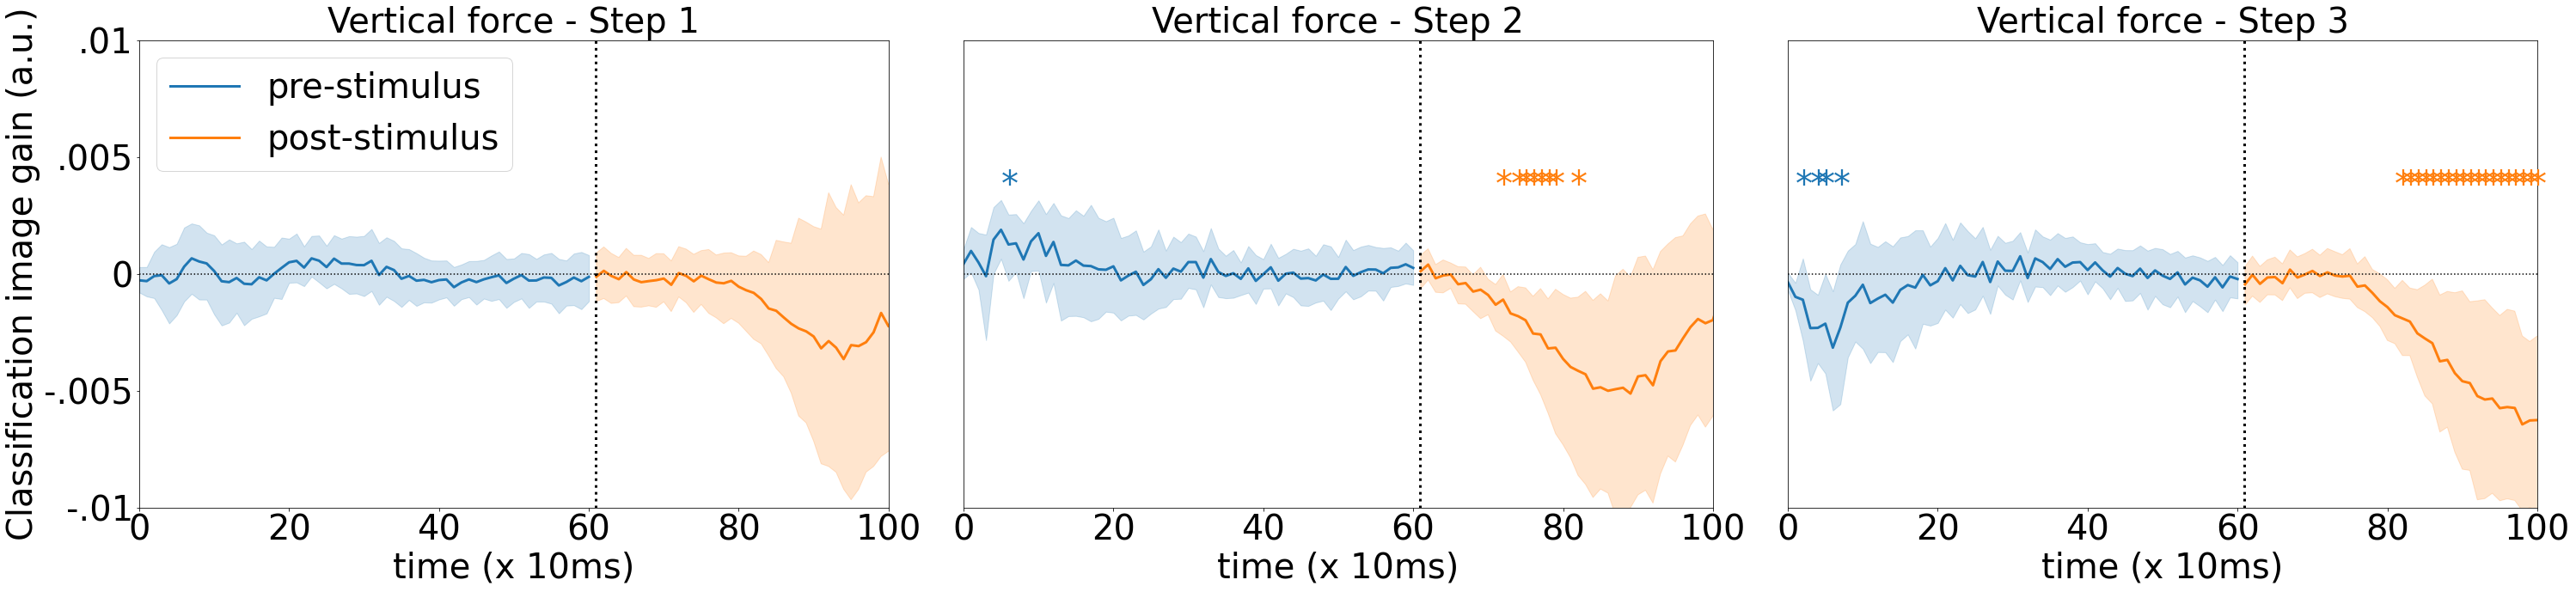

In [21]:
fig = plt.figure(figsize=(50,10))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
fontsize=40

for index,repeat in enumerate([1,2,3]): 
    
    kernels = compute_classification_image(data=z_data[z_data.repeat_index==repeat], 
                                 feature='z_value',
                                 criteria = 'log_pitch')
    
    participant_kernels = kernels.groupby(['participant','t']).gain.mean().reset_index()
    stats, sig_t = compute_one_sample_stats(participant_kernels)
    
    print('REPEAT_INDEX =%d'%repeat)
    for t,cell in sig_t:
        print('- %d: t(%d)=%.2f, p=%.3f'%(t,cell['dof'],cell['T'],cell['p-val']))
    
    plt.subplot(1,3,index+1)
    
    plot_classification_image(kernels=participant_kernels,
                              mean_time=mean_time,
                              stats=sig_t, 
                              ylabel = True if index == 0 else False, 
                              legend = False if repeat > 1 else 'brief',
                              fontsize=fontsize)
    plt.title ('Vertical force - Step %d'%repeat, fontsize=fontsize) 
    plt.xlabel('time (x 10ms)', fontsize=fontsize)
    if repeat == 1:
        plt.ylabel ('Classification image gain (a.u.)', fontsize=fontsize)
        plt.yticks(ticks=[-0.01,-.005,0,.005,.01], 
           labels=['-.01', '-.005', '0', '.005', '.01'], fontsize=fontsize)
            
            
plt.savefig('./pics/step_kernel_z.pdf', format='pdf', dpi=600, transparent=True)
 

### Repeated-measure correlations

This pattern of data is consistent with both the interpretation that participants' steps performed on tones with lower pitch were heavier (showing more vertical force), but also that these steps were longer: because classification images were computed by aggregating steps of varied duration, it is possible that steps that had (positive) vertical force for longer amounts of time occurred more often for lower pitch, and that shorter steps, whose vertical force reached zero earlier, were conversely associated with higher pitch. For a confirmatory analysis, we therefore computed separate repeated-measure correlations between the (log-transformed) pitch in each participant's trials and the weight (computed as the mean vertical force between 800 and 1000ms) and duration of the corresponding steps: both correlations were significant at step 3 (weight: r(2291)=-0.043  [-0.08, -0.0], p=.03; duration: r(2291)=-0.066 [-0.11, -0.03], p=.001).

In [11]:
freqs=[261,293,329,349,392,440,493,523,587,659,698,784,880,987]
notes=['C4','D4','E4','F4','G4','A4','B4','C5','D5','E5','F5','G5','A5','B5']

REPEAT 1
                r   dof      pval          CI95%     power
rm_corr -0.025838  2280  0.217262  [-0.07, 0.02]  0.234627
REPEAT 2
                r   dof      pval          CI95%     power
rm_corr -0.001272  2286  0.951528  [-0.04, 0.04]  0.050416
REPEAT 3
                r   dof      pval          CI95%     power
rm_corr -0.043979  2291  0.035221  [-0.08, -0.0]  0.558203


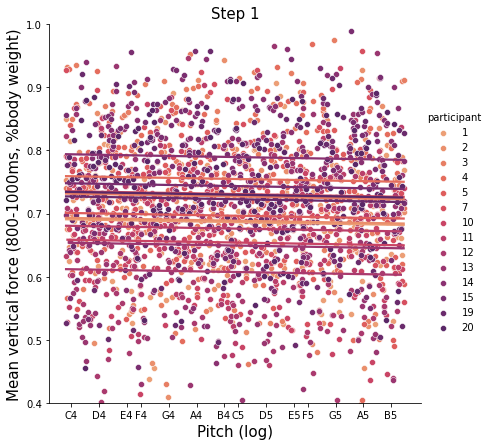

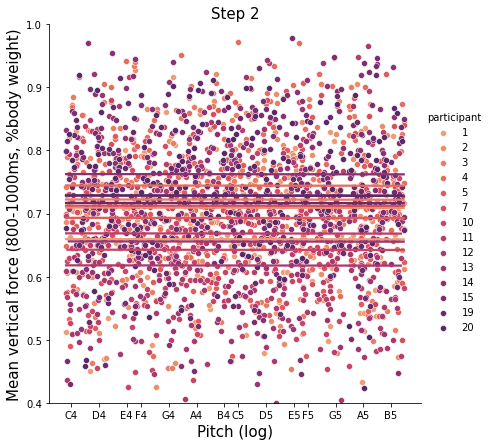

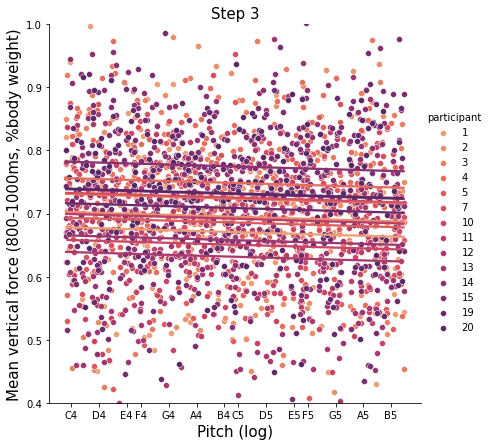

In [12]:
for repeat_index in [1,2,3]:
    corr_data = z_data[(z_data.t.isin(np.arange(80,100)))
         &(z_data.repeat_index==repeat_index)].groupby(['participant','log_pitch']).agg({'z_value':np.nanmean}).reset_index()
    
    print('REPEAT '+str(repeat_index))
    print(pg.rm_corr(data=corr_data, x='log_pitch', y='z_value', subject='participant'))
    pg.plot_rm_corr(data=corr_data, x='log_pitch', y='z_value', subject='participant', legend=True, 
                    kwargs_facetgrid=dict(height=6, aspect=1,palette='flare'))
    
    plt.title ('Step %d'%repeat_index, fontsize=15) 
    plt.xlabel('Pitch (log)', fontsize=15)
    plt.xticks(ticks=np.log(freqs), labels=notes, fontsize=10)
    plt.ylabel ('Mean vertical force (800-1000ms, %body weight)', fontsize=15)
    plt.ylim([0.4,1.0])

    
    plt.savefig('./pics/corr_weight_step%d.pdf'%repeat_index, format='pdf', dpi=600, transparent=True)
      
    #plt.ylim([0.8,1.1])


Effect size:

In [46]:
weight_difference = corr_data[corr_data.log_pitch >= np.log(freqs[-1:])[0]].groupby(['participant']).z_value.mean().reset_index().join(corr_data[corr_data.log_pitch <= np.log(freqs[0])].groupby(['participant']).z_value.mean().reset_index().set_index('participant'), on='participant', lsuffix='_high', rsuffix='_low')
weight_difference['diff'] = weight_difference.z_value_low - weight_difference.z_value_high
se = weight_difference['diff'].std()/np.sqrt(weight_difference['diff'].count())

print('The gain of weight from B5 to C4 is M=%.1f%% [%.2f,%.2f]'%(100*weight_difference['diff'].mean(),
                                                               100*(weight_difference['diff'].mean()-se/3.92),
                                                                100*(weight_difference['diff'].mean()+se/3.92)))

The gain of weight from B5 to C4 is M=3.6% [3.05,4.19]


REPEAT 1
                r   dof      pval          CI95%     power
rm_corr -0.020392  2280  0.330195  [-0.06, 0.02]  0.163701
REPEAT 2
                r   dof     pval          CI95%     power
rm_corr  0.005302  2286  0.79991  [-0.04, 0.05]  0.057386
REPEAT 3
                r   dof      pval           CI95%     power
rm_corr -0.066448  2291  0.001454  [-0.11, -0.03]  0.889747


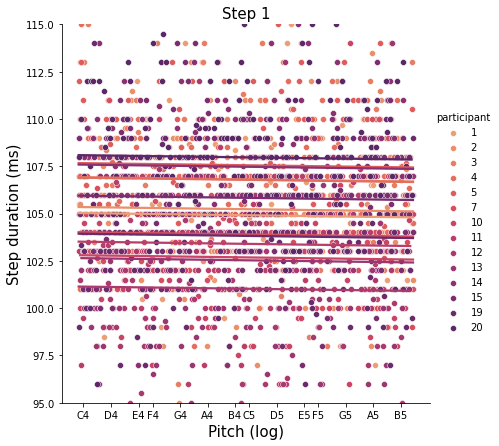

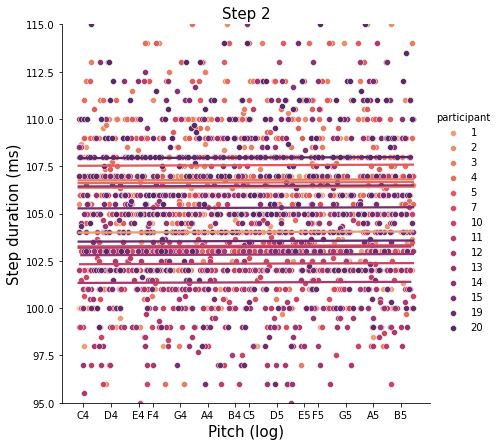

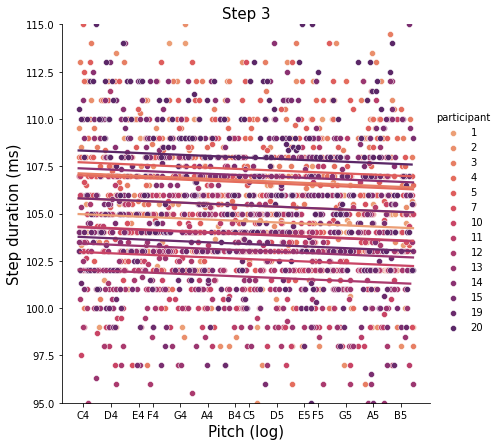

In [48]:
for repeat_index in [1,2,3]:
    corr_data = z_data[z_data.repeat_index==repeat_index].groupby(['participant','log_pitch']).agg({'len_z_value':np.nanmean}).reset_index()
    
    print('REPEAT '+str(repeat_index))
    print(pg.rm_corr(data=corr_data, x='log_pitch', y='len_z_value', subject='participant'))
    pg.plot_rm_corr(data=corr_data, x='log_pitch', y='len_z_value', subject='participant', legend=True, 
                    kwargs_facetgrid=dict(height=6, aspect=1,palette='flare'))
    plt.ylim([95,115])
    
    plt.title ('Step %d'%repeat_index, fontsize=15) 
    plt.xlabel('Pitch (log)', fontsize=15)
    plt.xticks(ticks=np.log(freqs), labels=notes, fontsize=10)
    plt.ylabel ('Step duration (ms)', fontsize=15)
    
    
    plt.savefig('./pics/corr_duration_step%d.pdf'%repeat_index, format='pdf', dpi=600, transparent=True)



Effect size:

In [55]:
duration_difference = corr_data[corr_data.log_pitch >= np.log(freqs[-1:])[0]].groupby(['participant']).len_z_value.mean().reset_index().join(corr_data[corr_data.log_pitch <= np.log(freqs[0])].groupby(['participant']).len_z_value.mean().reset_index().set_index('participant'), on='participant', lsuffix='_high', rsuffix='_low')
duration_difference['diff'] = duration_difference.len_z_value_low - duration_difference.len_z_value_high
se = duration_difference['diff'].std()/np.sqrt(duration_difference['diff'].count())

print('The gain of weight from B5 to C4 is M=%.1fms [%.2fms,%.2fms]'%(duration_difference['diff'].mean(),
                                                               duration_difference['diff'].mean()-se/3.92,
                                                                duration_difference['diff'].mean()+se/3.92))

The gain of weight from B5 to C4 is M=1.4ms [1.19ms,1.61ms]


### Control : normalized duration

In addition, to verify that musical pitch had an influence on stepping weight beyond the effect on step duration, we repeated the classification image analysis by normalizing all steps to 100\% duration. Classification images in the vertical dimension continued to exhibit a significant negative cluster at step 2 (from t=670 to 740ms, t(13)$\in$[-2.23,-3.72], all ps < .044), and repeated-measure correlations between log pitch and weight in the same range (700-750ms) remained consistent, albeit non significant: r(2286)=-0.034 [-0.08, 0.01], p=.09. All in one, we therefore found converging evidence that participants' steps were both longer and heavier when they stepped on musical notes with lower pitch. \hl{effect size}

#### Classification images

##### Vertical force - Z

In [22]:
norm_z_data = melt_time_series (data_in=data, feature='z',
                         normalize_time=True) 

In [23]:
kernels = compute_classification_image(norm_z_data, 
                                 feature='z_value',
                                 criteria = 'log_pitch')

participant_kernels = kernels.groupby(['participant','t']).gain.mean().reset_index()

In [24]:
stats, sig_t = compute_one_sample_stats(participant_kernels)
for t,cell in sig_t:
    print('- %d: t(%d)=%.2f, p=%.3f'%(t,cell['dof'],cell['T'],cell['p-val']))

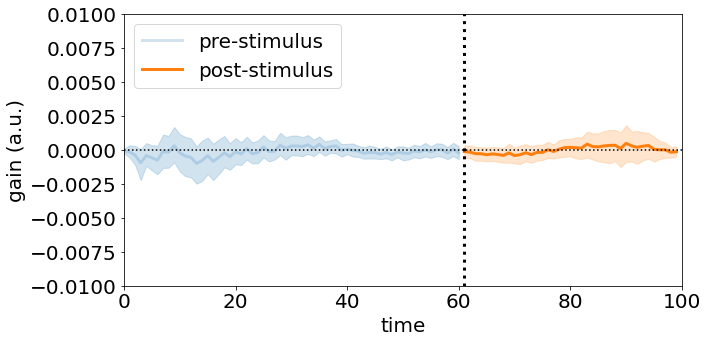

In [25]:
fig = plt.figure(figsize=(10,5))
plot_classification_image(kernels=participant_kernels,
                         mean_time=mean_time,
                         stats=sig_t, 
                         alphas=[0.2,1], fontsize=20)


REPEAT_INDEX =1
- 99: t(13)=-2.22, p=0.044
REPEAT_INDEX =2
- 67: t(13)=-2.23, p=0.044
- 68: t(13)=-3.11, p=0.008
- 70: t(13)=-3.72, p=0.003
- 71: t(13)=-3.00, p=0.010
- 72: t(13)=-2.70, p=0.018
- 73: t(13)=-2.88, p=0.013
- 74: t(13)=-2.89, p=0.013
REPEAT_INDEX =3
- 1: t(13)=-3.06, p=0.009
- 3: t(13)=-2.58, p=0.023
- 4: t(13)=-2.99, p=0.011
- 5: t(13)=-2.38, p=0.033
- 6: t(13)=-2.61, p=0.022


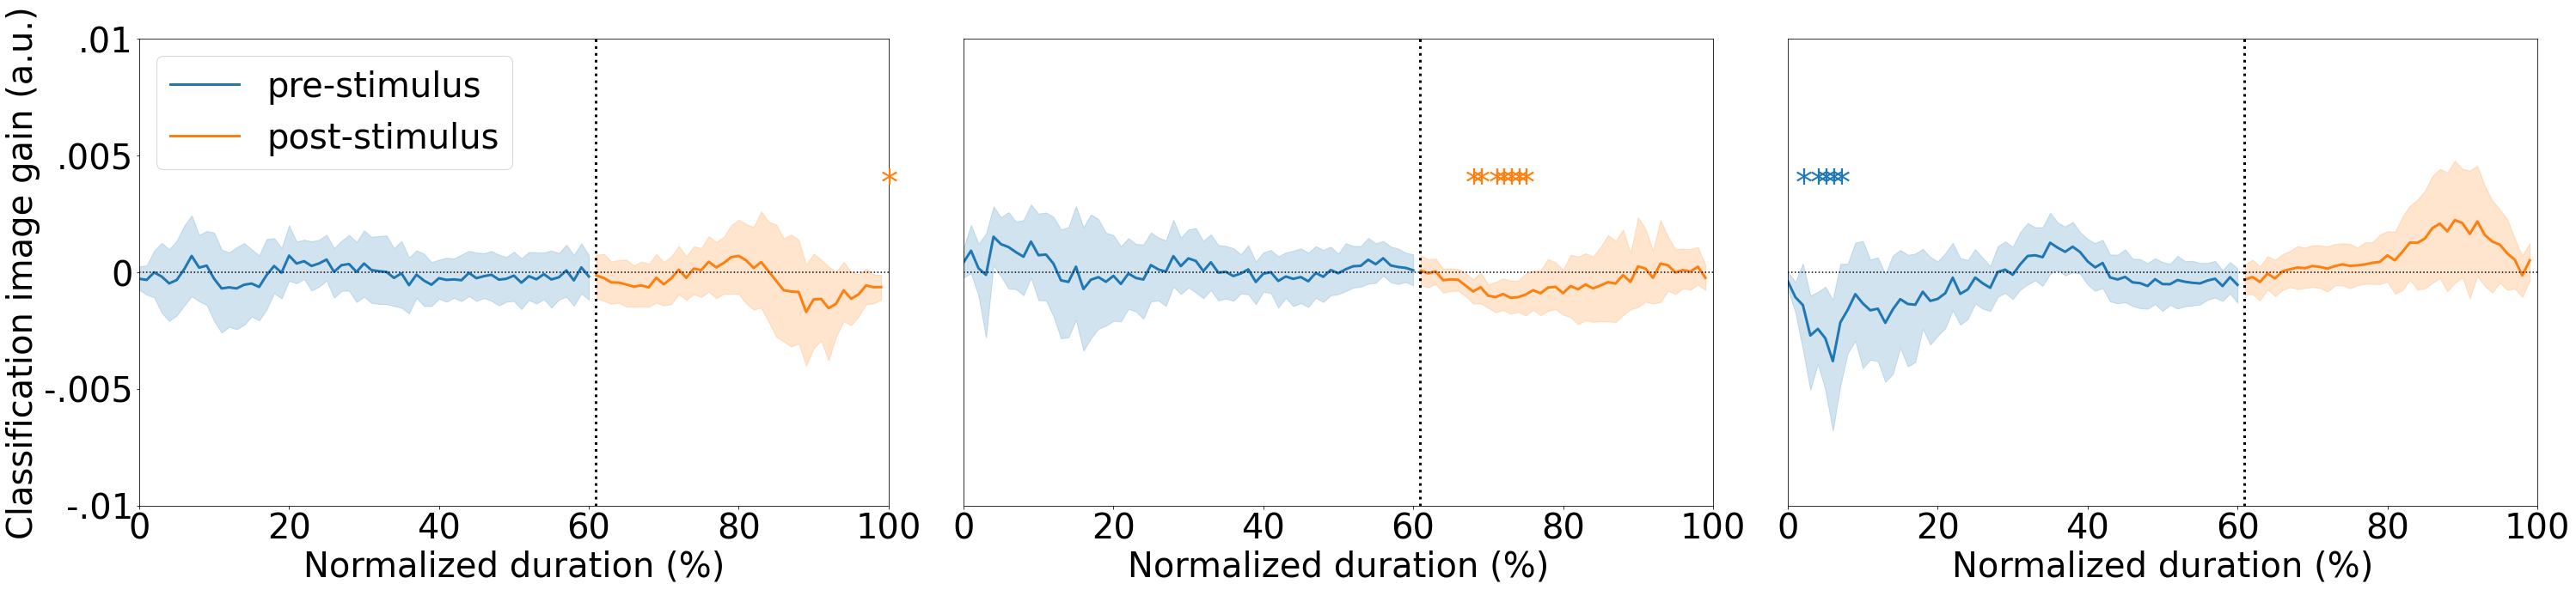

In [28]:
fig = plt.figure(figsize=(50,10))
plt.subplots_adjust(wspace=0.1,hspace=0.1)
fontsize=40

for index,repeat in enumerate([1,2,3]): 
    
    kernels = compute_classification_image(data=norm_z_data[norm_z_data.repeat_index==repeat], 
                                 feature='z_value',
                                 criteria = 'log_pitch')
    
    participant_kernels = kernels.groupby(['participant','t']).gain.mean().reset_index()
    stats, sig_t = compute_one_sample_stats(participant_kernels)
    
    print('REPEAT_INDEX =%d'%repeat)
    for t,cell in sig_t:
        print('- %d: t(%d)=%.2f, p=%.3f'%(t,cell['dof'],cell['T'],cell['p-val']))
    
    plt.subplot(1,3,index+1)
    
    plot_classification_image(kernels=participant_kernels,
                              mean_time=mean_time,
                              stats=sig_t, 
                              ylabel = True if index == 0 else False, 
                              legend = False if repeat > 1 else 'brief',
                              fontsize=fontsize)
    #plt.title ('Vertical force - Step %d'%repeat, fontsize=fontsize) 
    plt.xlabel('Normalized duration (%)', fontsize=fontsize)
    if repeat == 1:
        plt.ylabel ('Classification image gain (a.u.)', fontsize=fontsize)
        plt.yticks(ticks=[-0.01,-.005,0,.005,.01], 
           labels=['-.01', '-.005', '0', '.005', '.01'], fontsize=fontsize)
            
plt.savefig('./pics/step_kernel_norm_z.pdf', format='pdf', dpi=600, transparent=True)
            
    

#### Correlation

In [ ]:
for repeat_index in [1,2,3]:
    corr_data = norm_z_data[(norm_z_data.t.isin(np.arange(70,75)))
         &(norm_z_data.repeat_index==repeat_index)].groupby(['participant','log_pitch']).agg({'z_value':np.nanmean}).reset_index()
    
    print('REPEAT '+str(repeat_index))
    print(pg.rm_corr(data=corr_data, x='log_pitch', y='z_value', subject='participant'))
    pg.plot_rm_corr(data=corr_data, x='log_pitch', y='z_value', subject='participant', legend=True, 
                    kwargs_facetgrid=dict(height=6, aspect=1,palette='flare'))
    #plt.ylim([0.8,1.1])
    plt.savefig('./pics/corr_weight_norm_z_%d.pdf'%repeat_index, format='pdf', dpi=600, transparent=True)



### Musicianship

Finally, to test whether the influence of pitch was an effect of musical inculturation, we tested for possible differences between the classification images of musically- and non-musically trained participants, using paired t-tests at each time point. There was no difference between both types of participants at any time point, for any of the effects we tested, regardless of whether we used reported training or a standard test of musicianship (Gold-MSI) as a cutoff measure (e.g. vertical force, all ps > .55 from t=80 to 100ms).

In [ ]:
# kernels musicians
kernels_musicians = compute_classification_image(z_data[z_data.musician=='oui'], 
                                 feature='z_value',
                                 criteria = 'log_pitch')
participant_kernels_musicians = kernels_musicians.groupby(['participant','t']).gain.mean().reset_index()

# kernels musicians
kernels_non_musicians = compute_classification_image(z_data[z_data.musician=='non'], 
                                 feature='z_value',
                                 criteria = 'log_pitch')
participant_kernels_non_musicians = kernels_non_musicians.groupby(['participant','t']).gain.mean().reset_index()

# stats
stats, two_sig_t = compute_two_sample_stats(participant_kernels_musicians,
                                 participant_kernels_non_musicians)

for t,cell in stats:
        print('- %d: t(%d)=%.2f, p=%.3f'%(t,cell['dof'],cell['T'],cell['p-val']))

In [ ]:
fig = plt.figure(figsize=(10,5))

for musician in ['oui','non']: 
        
    # compute musician kernels 
    kernels = compute_classification_image(data=z_data[z_data.musician==musician], 
                                 feature='z_value',
                                 criteria = 'log_pitch')
    
    participant_kernels = kernels.groupby(['participant','t']).gain.mean().reset_index()
        
    #print("MUSICIAN %s"%musician)
    #for t,cell in stats:
    #    print('- %d: t(%d)=%.2f, p=%.3f'%(t,cell['dof'],cell['T'],cell['p-val']))
    
    plot_classification_image(kernels=participant_kernels,
                                  mean_time=mean_time,
                                  stats=sig_t, 
                                  ylabel = True if index == 0 else False, 
                                  fontsize=20,
                                  legend = 'brief',
                                  label='musician, ' if musician =='oui' else 'non-musician, ')
    plt.title ('Vertical force', fontsize=20) 
    plt.xlabel('time (x10ms)')
    plt.ylabel('gain (a.u.)')
    plt.legend(loc=2,fontsize=10)
            
plt.savefig('./pics/kernel_z_musician.pdf', format='pdf', dpi=600, transparent=True)
      
    